In [1]:
### SETTING AMBIENTE
# Garantisce versioni compatibili e stabili di numpy, pandas e pmdarima

import importlib.util, subprocess, sys

def ensure_package(pkg, version=None):
    pkg_str = f"{pkg}=={version}" if version else pkg
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg_str])

# Controllo versioni numpy e pandas
import numpy as np, pandas as pd
if not np.__version__.startswith("1.26"):
    print(f"[X] Trovata numpy {np.__version__}, reinstallo 1.26.4...")
    ensure_package("numpy", "1.26.4")

if pd.__version__ != "2.2.2":
    print(f"[X] Trovata pandas {pd.__version__}, reinstallo 2.2.2...")
    ensure_package("pandas", "2.2.2")

# Installa pmdarima se mancante
if importlib.util.find_spec("pmdarima") is None:
    ensure_package("pmdarima", "2.0.4")

# Import finale e stampa versioni
import pmdarima as pm
print(f"[OK] numpy: {np.__version__} | pandas: {pd.__version__} | pmdarima: {pm.__version__}")



[OK] numpy: 1.26.4 | pandas: 2.2.2 | pmdarima: 2.0.4


In [27]:
### SETUP LIBRERIE

# (Se non già installato, scommentare la riga sotto per installare pandas_ta)
#!pip install --quiet pandas_ta

#Data
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader.data as web

#Plots & Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import seaborn as sns

#Statistics
from scipy import stats
from scipy import optimize
import statsmodels.api as sm

#Forecast
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

#Machine Learning
from sklearn.ensemble import RandomForestClassifier

#Metriche di errore
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Indicatori technical analysis
import pandas_ta as ta

#Utility
from itertools import combinations

#Impostazioni grafiche
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 5)




In [3]:
###
### FASE 1 — Dati
###

tickers = ["V","MA","JNJ","PFE","META","AMZN","LMT","CAT"]


# Scarico i dati giornalieri
data = yf.download(tickers, start="2014-05-31", end="2024-05-31", auto_adjust=True)["Close"]


bench_raw = yf.download("^GSPC", start="2014-05-31", end="2024-05-31", auto_adjust=True)

close_obj = bench_raw["Close"]          # Può essere Series o DataFrame a 1 colonna
if isinstance(close_obj, pd.DataFrame): # MultiIndex => prendi la prima colonna
    benchmark = close_obj.iloc[:, 0].rename("SP500")
else:
    benchmark = close_obj.rename("SP500")

# Unisco i dati in un unico DataFrame
all_data = pd.concat([data, benchmark], axis=1)


all_data.to_csv("prezzi_giornalieri.csv")

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-427051370.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = all_data_filled.resample('M').last().dropna(how='all')


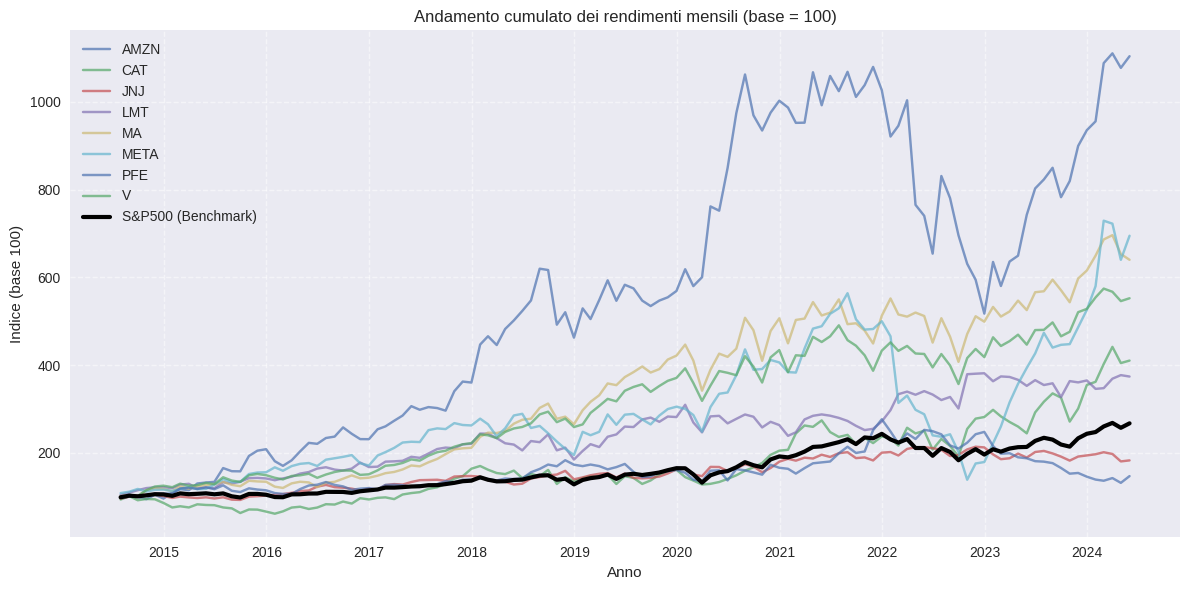

In [4]:
### PREZZI MENSILI

# Riempie piccoli “buchi” giornalieri (weekend/festivi) prima del resample; limit=5 evita di propagare troppo in avanti eventuali buchi lunghi.
all_data_filled = all_data.sort_index().ffill(limit=5)

# Ultimo valore valido di ogni mese
monthly_prices = all_data_filled.resample('M').last().dropna(how='all')

monthly_prices.to_csv("prezzi_mensili.csv", index=True)


### RENDIMENTI MENSILI (semplici e logaritmici)

# dropna() elimina i mesi iniziali fino a che tutti i titoli hanno dati disponibili
monthly_returns = monthly_prices.pct_change().dropna()
monthly_log_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

monthly_returns.to_csv("rendimenti_mensili.csv", index=True)
monthly_log_returns.to_csv("rendimenti_log_mensili.csv", index=True)


### Andamento cumulato dei rendimenti (base 100)

cumulative_returns = (1 + monthly_returns).cumprod() * 100

plt.figure(figsize=(12,6))
for c in cumulative_returns.columns:
    if c == "SP500":
        plt.plot( cumulative_returns.index, cumulative_returns[c],
                  color="black", lw=3, label="S&P500 (Benchmark)" )
    else:
        plt.plot( cumulative_returns.index, cumulative_returns[c],
                  alpha=0.7, label=c )

plt.title('Andamento cumulato dei rendimenti mensili (base = 100)')
plt.xlabel('Anno')
plt.ylabel('Indice (base 100)')
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
###
###FASE 2
###


### CAGR

def compute_cagr(prices: pd.DataFrame) -> pd.Series:
    start = prices.iloc[0]
    end = prices.iloc[-1]
    n_years = (prices.index[-1] - prices.index[0]).days / 365.25
    return (end / start) ** (1 / n_years) - 1

cagr = compute_cagr(monthly_prices)
cagr = cagr.rename("CAGR")

### Statistiche annualizzate da rendimenti mensili

mean_ann = monthly_returns.mean() * 12
var_ann  = monthly_returns.var(ddof=1) * 12
std_ann  = monthly_returns.std(ddof=1) * np.sqrt(12)
skew = monthly_returns.apply(lambda x: stats.skew(x.dropna(), bias=False))
kurt_excess = monthly_returns.apply(lambda x: stats.kurtosis(x.dropna(), fisher=True, bias=False))
kurt = kurt_excess + 3

stats_ann = pd.DataFrame({
    "mean_ann": mean_ann,
    "var_ann": var_ann,
    "std_ann": std_ann,
    "skewness": skew,
    "kurtosis": kurt
})


cagr.to_csv("cagr.csv", header=True)
stats_ann.to_csv("statistiche_descrittive_annualizzate.csv")


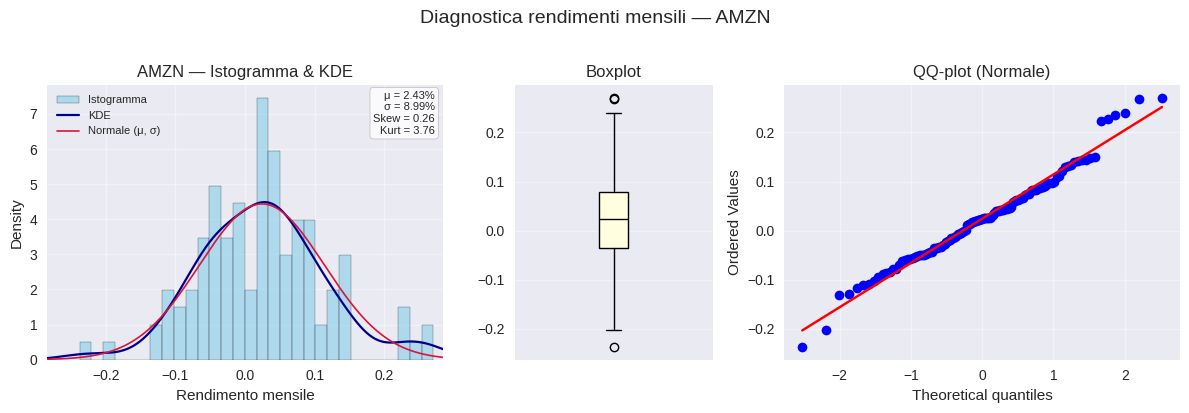

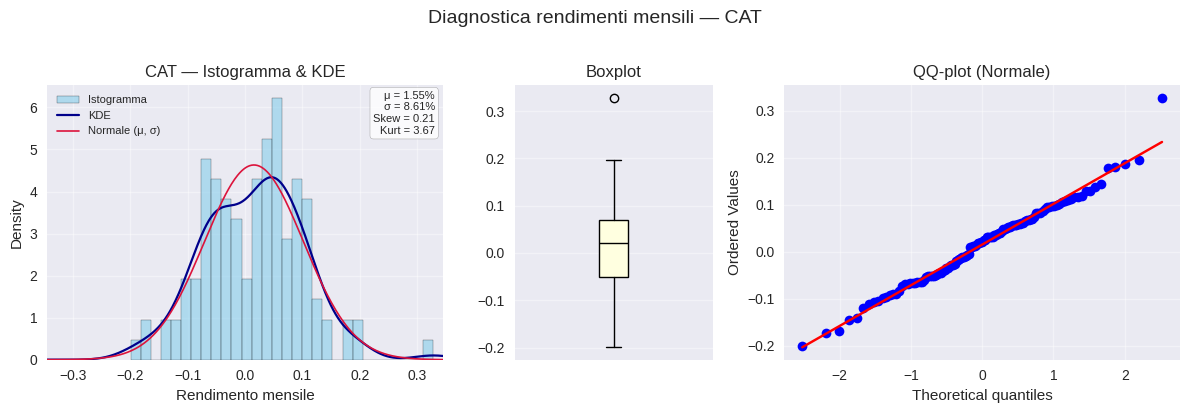

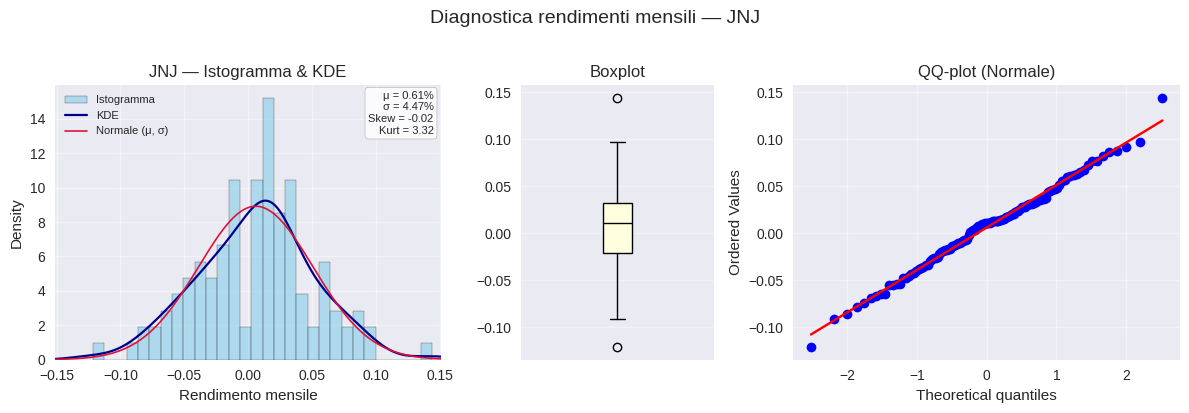

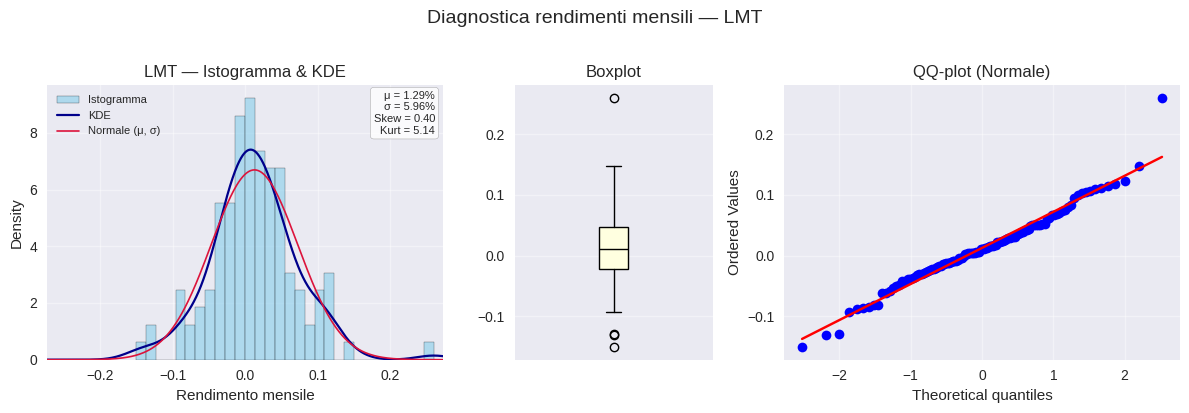

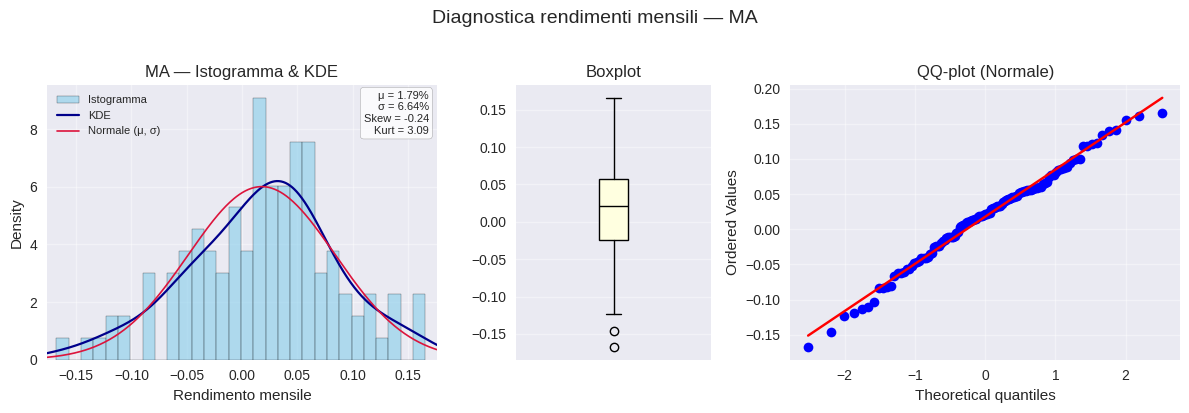

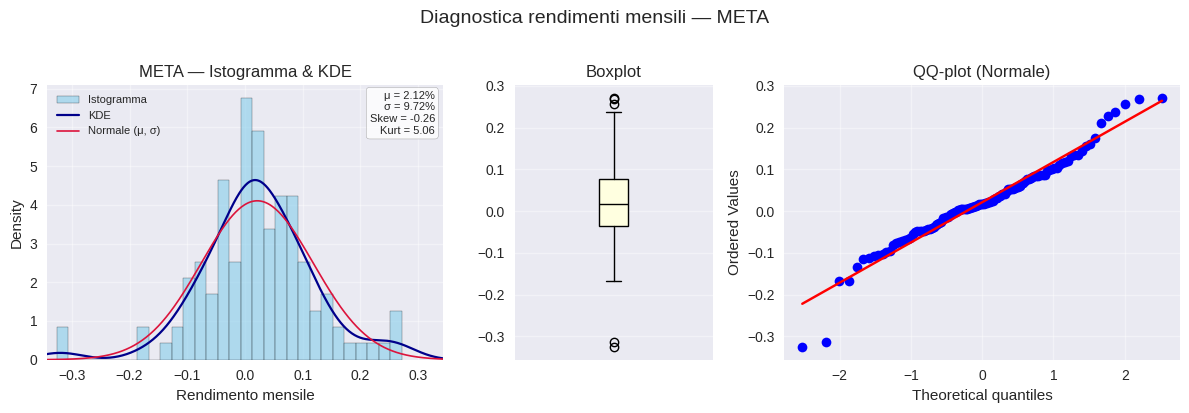

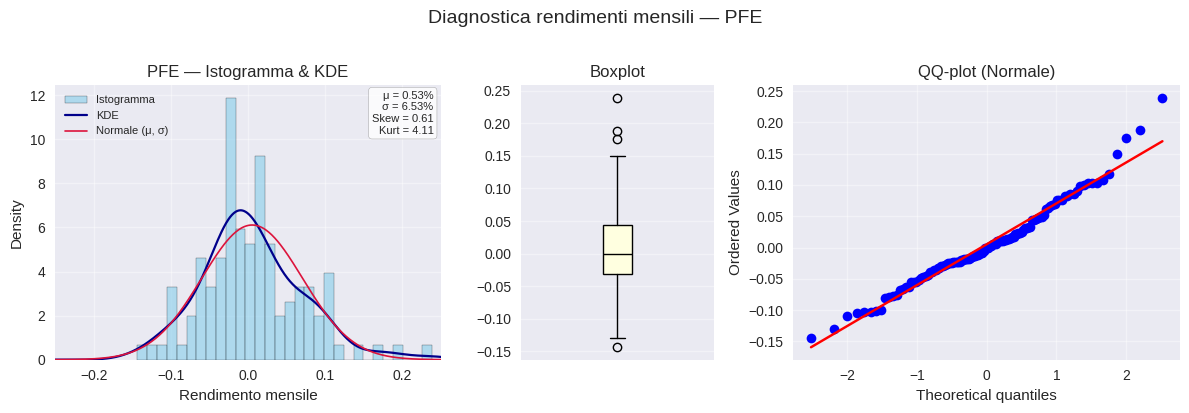

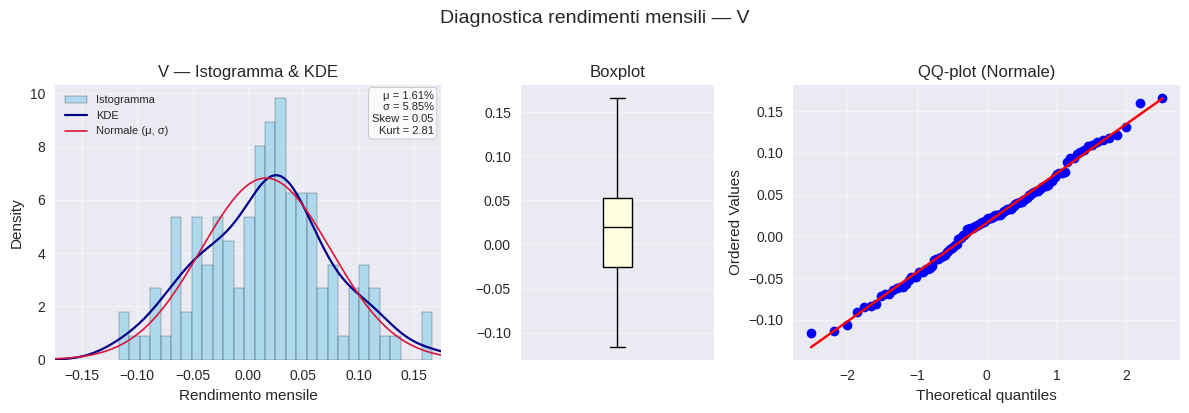

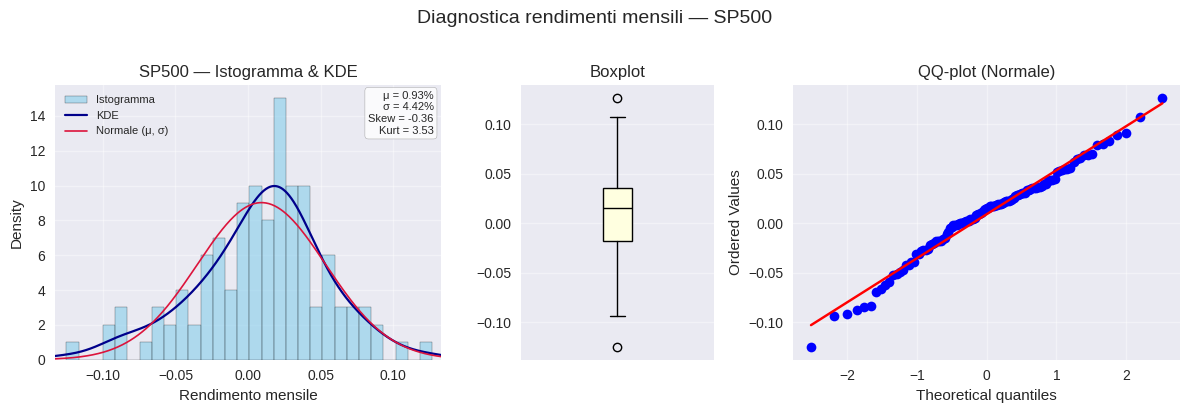

In [6]:
### Diagnostica rendimenti mensili: istogramma+KDE, boxplot, QQ-plot


def diagnostic_plots_for_ticker(serie: pd.Series, ticker: str):
    r = serie.dropna()
    if len(r) < 20:
        return

    m = max(abs(r.min()), abs(r.max()))
    x_min, x_max = -m*1.05, m*1.05

    # Stima normale
    mu = r.mean()
    sd = r.std(ddof=1)
    xgrid = np.linspace(x_min, x_max, 400)
    normal_pdf = stats.norm.pdf(xgrid, loc=mu, scale=sd) if sd > 0 else np.zeros_like(xgrid)

    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 2])

    # Istogramma & KDE
    ax1 = plt.subplot(gs[0])
    ax1.hist(r, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Istogramma')
    r.plot(kind="kde", ax=ax1, color='darkblue', lw=1.6, label='KDE')
    if sd > 0:
        ax1.plot(xgrid, normal_pdf, color='crimson', lw=1.2, label='Normale (μ, σ)')
    ax1.set_xlim(x_min, x_max)
    ax1.set_title(f"{ticker} — Istogramma & KDE")
    ax1.set_xlabel("Rendimento mensile")
    ax1.grid(True, alpha=0.4)
    ax1.legend(frameon=False, fontsize=8)

    # Boxplot
    ax2 = plt.subplot(gs[1])
    ax2.boxplot(r, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightyellow', edgecolor='black'),
                medianprops=dict(color='black'))
    ax2.set_title("Boxplot")
    ax2.set_xticks([])
    ax2.grid(True, alpha=0.4)

    # QQ-plot
    ax3 = plt.subplot(gs[2])
    stats.probplot(r, dist="norm", plot=ax3)
    ax3.set_title("QQ-plot (Normale)")
    ax3.grid(True, alpha=0.4)

    # Statistiche descrittive
    text = (f"μ = {mu*100:.2f}%\n"
            f"σ = {sd*100:.2f}%\n"
            f"Skew = {stats.skew(r, bias=False):.2f}\n"
            f"Kurt = {stats.kurtosis(r, fisher=False, bias=False):.2f}")
    ax1.text(0.98, 0.98, text, transform=ax1.transAxes,
             ha="right", va="top", fontsize=8,
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))

    plt.suptitle(f"Diagnostica rendimenti mensili — {ticker}", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


for col in monthly_returns.columns:
    diagnostic_plots_for_ticker(monthly_returns[col], col)

In [7]:
from scipy import stats
assets = [c for c in monthly_returns.columns if c.upper() != "SP500"]

def jb_for_series(s):
    s = s.dropna()
    stat, p = stats.jarque_bera(s)
    return pd.Series({"JB_stat": stat, "JB_p": p})

jb = monthly_returns[assets].apply(jb_for_series)
display(jb.round(4))

AMZN     CAT     JNJ      LMT      MA     META      PFE       V
JB_stat  3.6376  2.6018  0.3472  22.8564  1.1258  19.7199  12.2410  0.3025
JB_p     0.1622  0.2723  0.8407   0.0000  0.5695   0.0001   0.0022  0.8596

In [8]:
### TOP/BOTTOM 2 MESI PER OGNI TITOLO

ret_m = monthly_returns.copy()

# mesi per lato
N = 2

# Eventi GENERICI (fallback) per date ricorrenti di mercato
GENERIC_EVENTS = {
    "2014-10": "Rimbalzo post sell-off",
    "2016-01": "Sell-off globale (Cina/commodities)",
    "2018-10": "Risk-off su tassi/growth",
    "2018-12": "Christmas sell-off (Fed/crescita)",
    "2019-01": "Fed più dovish (mini pivot)",
    "2020-02": "Inizio sell-off COVID",
    "2020-03": "Shock COVID",
    "2020-04": "Rimbalzo post-shock",
    "2020-06": "Rotazione risk-on (difensivi deboli)",
    "2020-07": "Progressi vaccini/trial",
    "2020-08": "Riaperture; travel in risalita",
    "2020-10": "Nuove restrizioni UE; travel debole",
    "2020-11": "Vaccini / re-opening",
    "2022-02": "Guerra Russia–Ucraina",
    "2022-03": "Boom commodities/capex",
    "2022-06": "Fed 75 bps + QT; recessione",
    "2022-07": "Peak-inflation; utili migliori",
    "2022-09": "Fed molto hawkish (dots alti)",
    "2022-10": "Rally da minimi; tassi in calo",
    "2022-11": "CPI sotto attese → rally risk",
    "2023-06": "Macro resiliente; infrastrutture USA",
    "2023-10": "US 10Y ai massimi → risk-off",
    "2023-11": "Rally da ‘Fed pivot’",
    "2024-02": "Conti forti / buyback (ampio)"
}

# Eventi SPECIFICI per ticker (sovrascrivono i generici se stessa data)
EVENTS_BY_TICKER = {
    "AMZN": {
        "2018-01": "Risk-on tech inizio 2018",
        "2022-04": "Q1 sotto attese; guida e-commerce debole",
        "2022-07": "Post-trimestrale; AWS solido",
    },
    "CAT": {
        "2022-03": "Commodities/capex in boom",
        "2022-10": "Rally da minimi; rotazione ciclici (CPI reversal)",  # ← correzione
        "2023-06": "Infra USA; backlog solido",
    },
    "JNJ": {
        "2018-07": "Trimestrale solida",
        "2020-04": "Rimbalzo post-shock",
        "2021-12": "Flussi difensivi di fine anno",
        "2024-04": "Talc litigation/news",
    },
    "LMT": {
        "2022-02": "Escalation Ucraina (difesa bid)",
        "2022-10": "Q3 > attese; buyback",
    },
    "MA": {
        "2020-08": "Riaperture; cross-border su",
        "2020-11": "Vaccini / re-opening",
        "2022-10": "Q3 > attese; cross-border forte",
    },
    "META": {
        "2019-01": "Fed più dovish",
        "2022-02": "Post-trim: guida debole; IDFA",
        "2022-10": "Post Q3: Reality Labs; guida debole",  # ← correzione
        "2024-02": "Conti forti; 1° dividendo; buyback",
    },
    "PFE": {
        "2020-07": "Progressi vaccino",
        "2021-11": "Paxlovid: dati positivi",
        "2023-01": "Normalizzazione post-COVID; guida prudente",
    },
    "SP500": {
        "2020-11": "Vaccini / re-opening",
        "2022-07": "Peak-inflation; utili migliori",
    },
    "V": {
        "2014-10": "Rimbalzo post sell-off",
        "2020-11": "Vaccini / re-opening",
        "2021-01": "Rotazione ciclici; travel debole",
        "2022-10": "Q4 FY22 > attese; cross-border solido",
    },
}

def event_label_for(ticker: str, date_str: str) -> str:
    """Priorità: evento specifico per ticker, poi generico, altrimenti vuoto."""
    return EVENTS_BY_TICKER.get(ticker, {}).get(date_str, GENERIC_EVENTS.get(date_str, ""))

def build_top_bottom_table(df: pd.DataFrame, n=2) -> pd.DataFrame:
    rows = []
    for col in df.columns:
        s = df[col].dropna()
        top = s.nlargest(n)
        bottom = s.nsmallest(n)

        for rank, (idx, val) in enumerate(top.items(), 1):
            date_str = idx.strftime("%Y-%m")
            rows.append({
                "Ticker": col, "Tipo": "Top", "Rank": rank,
                "Data": date_str,
                "Evento": event_label_for(col, date_str),
                "Rendimento": val
            })
        for rank, (idx, val) in enumerate(bottom.items(), 1):
            date_str = idx.strftime("%Y-%m")
            rows.append({
                "Ticker": col, "Tipo": "Bottom", "Rank": rank,
                "Data": date_str,
                "Evento": event_label_for(col, date_str),
                "Rendimento": val
            })
    out = pd.DataFrame(rows).sort_values(["Ticker","Tipo","Rank"])
    return out

tb_long_2 = build_top_bottom_table(ret_m, N)

tb_wide_2 = (
    tb_long_2
    .assign(Label=lambda d: d["Tipo"] + " " + d["Rank"].astype(str))
    .pivot_table(index="Ticker", columns="Label", values=["Data","Evento","Rendimento"], aggfunc="first")
)

labels_order = [f"Top {i}" for i in range(1, N+1)] + [f"Bottom {i}" for i in range(1, N+1)]
tb_wide_2.columns = [f"{lvl1} ({lvl2})" for lvl1, lvl2 in tb_wide_2.columns]
ordered_cols = []
for t in labels_order:
    ordered_cols += [f"Data ({t})", f"Evento ({t})", f"Rendimento ({t})"]
tb_wide_2 = tb_wide_2.reindex(columns=[c for c in ordered_cols if c in tb_wide_2.columns])

tb_wide_2_fmt = tb_wide_2.copy()
for c in tb_wide_2_fmt.columns:
    if c.startswith("Rendimento"):
        tb_wide_2_fmt[c] = (tb_wide_2[c]*100).map(lambda x: f"{x:+.2f}%")

display(tb_wide_2_fmt)
tb_wide_2_fmt.to_csv("top_bottom2_months.csv")



Data (Top 1)                                     Evento (Top 1)  \
Ticker                                                                   
AMZN        2022-07                       Post-trimestrale; AWS solido   
CAT         2022-10  Rally da minimi; rotazione ciclici (CPI reversal)   
JNJ         2020-04                                Rimbalzo post-shock   
LMT         2022-10                               Q3 > attese; buyback   
MA          2020-11                               Vaccini / re-opening   
META        2019-01                                     Fed più dovish   
PFE         2021-11                            Paxlovid: dati positivi   
SP500       2020-04                                Rimbalzo post-shock   
V           2022-10              Q4 FY22 > attese; cross-border solido   

       Rendimento (Top 1) Data (Top 2)                 Evento (Top 2)  \
Ticker                                                                  
AMZN              +27.06%      2020-04            Rimbalzo post-shock   
CAT               +32.81%      2023-06      Infra USA; backlog solido   
JNJ               +14.42%      2021-12  Flussi difensivi di fine anno   
LMT               +25.99%      2020-04            Rimbalzo post-shock   
MA                +16.58%      2020-08    Riaperture; cross-border su   
META              +27.16%      2022-11  CPI sotto attese → rally risk   
PFE               +23.92%      2020-07              Progressi vaccino   
SP500             +12.68%      2020-11           Vaccini / re-opening   
V                 +16.61%      2020-11           Vaccini / re-opening   

       Rendimento (Top 2) Data (Bottom 1)  \
Ticker                                      
AMZN              +26.89%         2022-04   
CAT               +19.59%         2018-10   
JNJ                +9.71%         2018-12   
LMT               +14.78%         2018-10   
MA                +16.10%         2020-03   
META              +26.77%         2022-02   
PFE               +18.83%         2020-06   
SP500             +10.75%         2020-03   
V                 +15.94%         2021-01   

                               Evento (Bottom 1) Rendimento (Bottom 1)  \
Ticker                                                                   
AMZN    Q1 sotto attese; guida e-commerce debole               -23.75%   
CAT                     Risk-off su tassi/growth               -19.93%   
JNJ            Christmas sell-off (Fed/crescita)               -12.15%   
LMT                     Risk-off su tassi/growth               -15.06%   
MA                                   Shock COVID               -16.78%   
META               Post-trim: guida debole; IDFA               -32.63%   
PFE         Rotazione risk-on (difensivi deboli)               -14.38%   
SP500                                Shock COVID               -12.51%   
V               Rotazione ciclici; travel debole               -11.65%   

       Data (Bottom 2)                           Evento (Bottom 2)  \
Ticker                                                               
AMZN           2018-10                    Risk-off su tassi/growth   
CAT            2022-06                 Fed 75 bps + QT; recessione   
JNJ            2020-02                       Inizio sell-off COVID   
LMT            2020-02                       Inizio sell-off COVID   
MA             2020-10         Nuove restrizioni UE; travel debole   
META           2022-10         Post Q3: Reality Labs; guida debole   
PFE            2023-01  Normalizzazione post-COVID; guida prudente   
SP500          2022-09               Fed molto hawkish (dots alti)   
V              2020-03                                 Shock COVID   

       Rendimento (Bottom 2)  
Ticker                        
AMZN                 -20.22%  
CAT                  -17.18%  
JNJ                   -9.09%  
LMT                  -13.06%  
MA                   -14.55%  
META                 -31.34%  
PFE                  -13.03%  
SP500                 -9.34

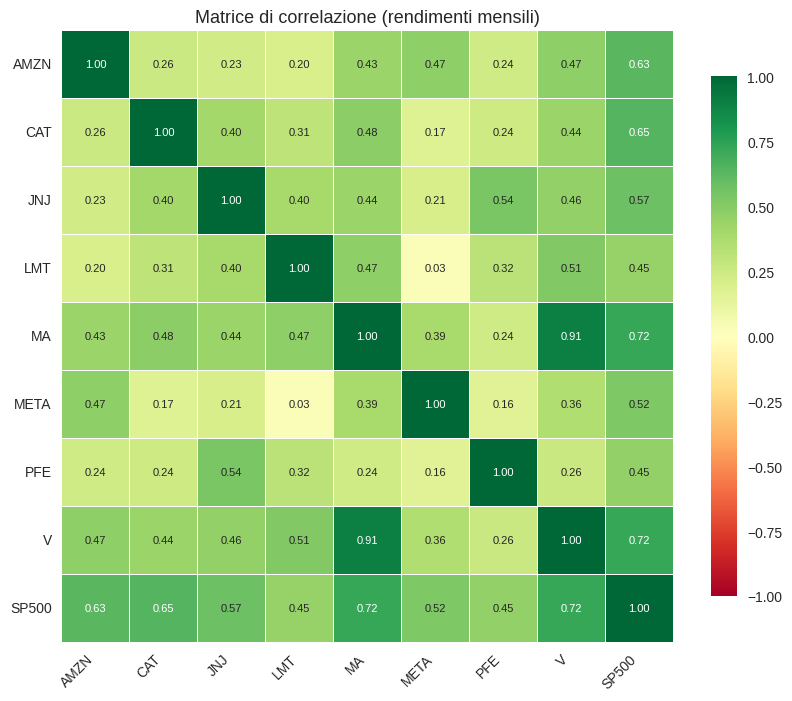

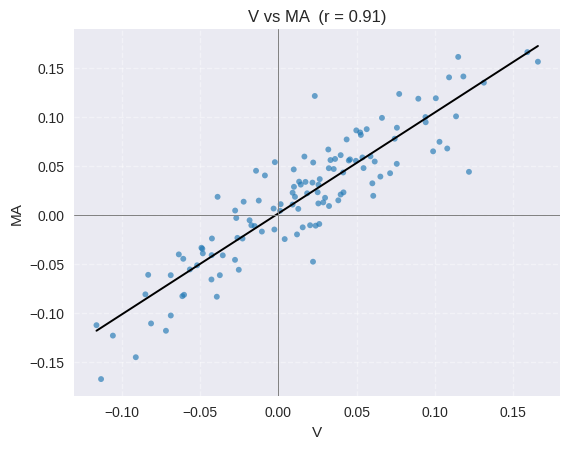

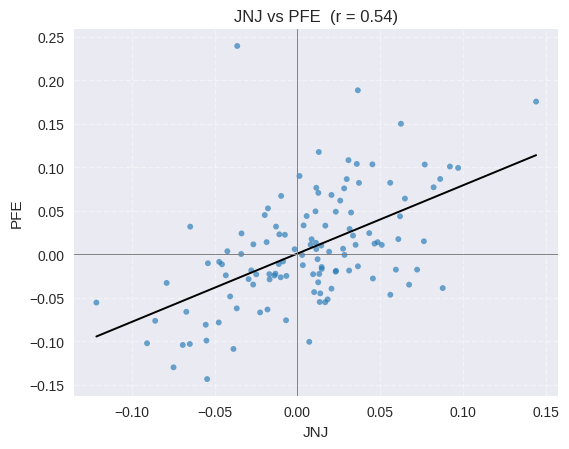

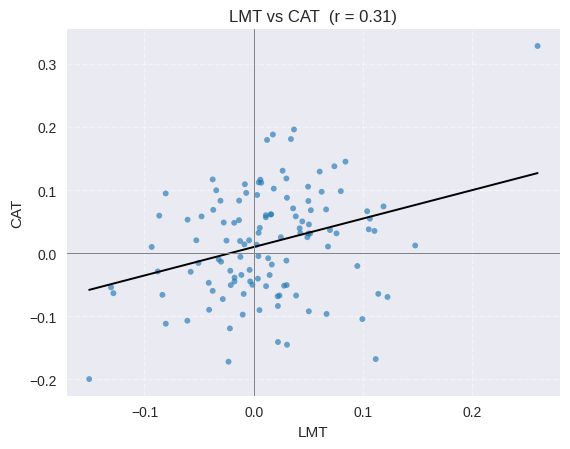

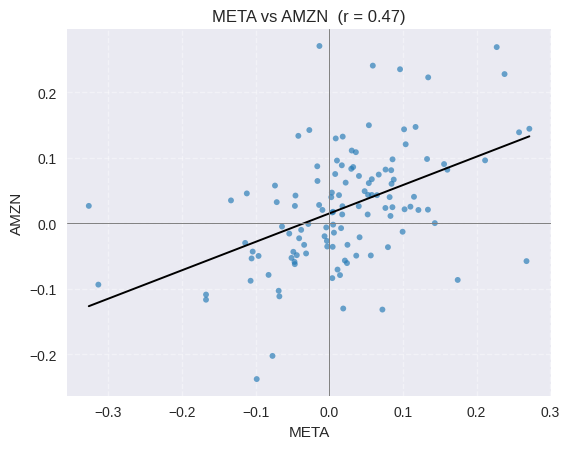

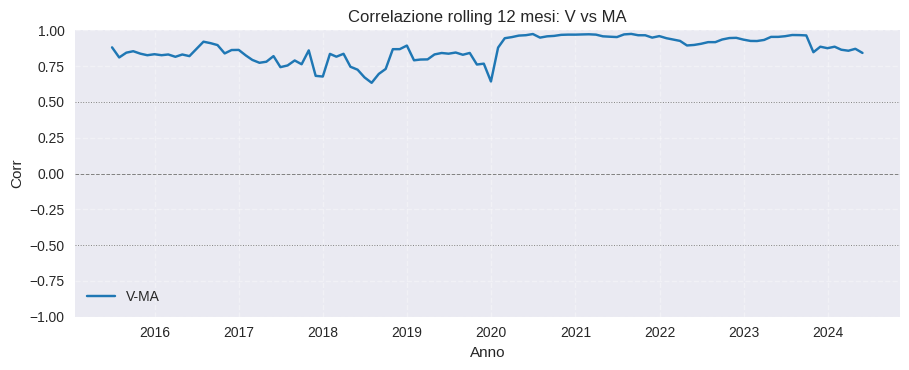

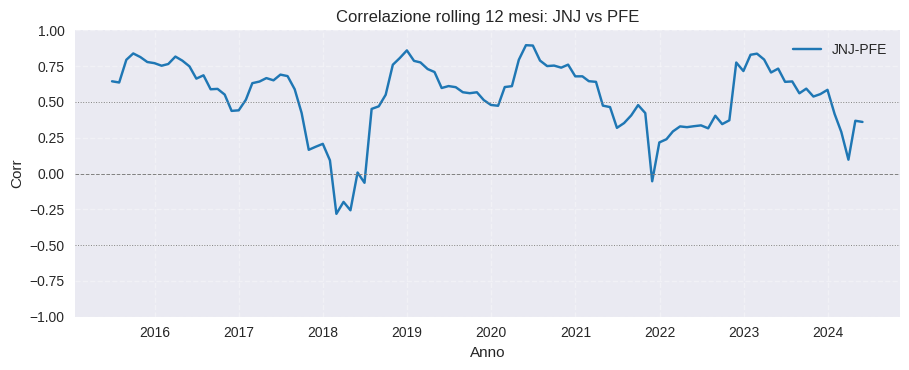

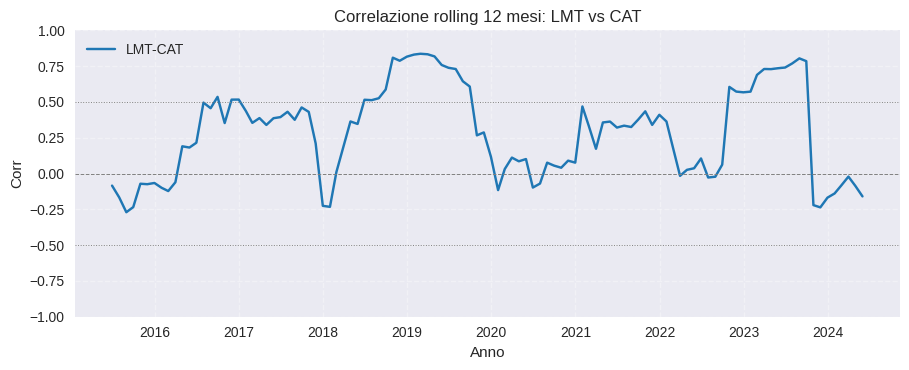

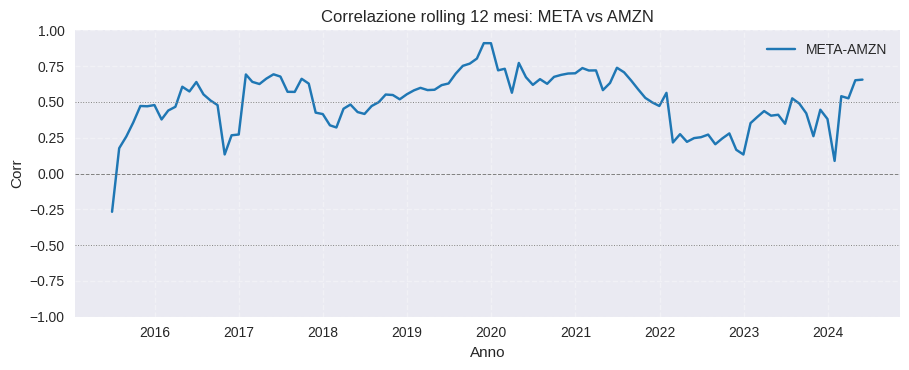

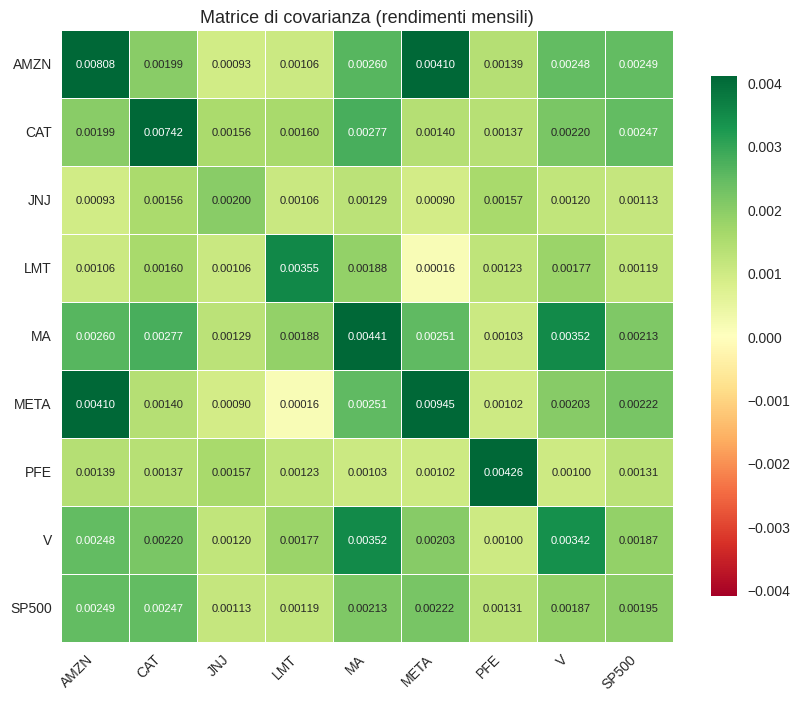

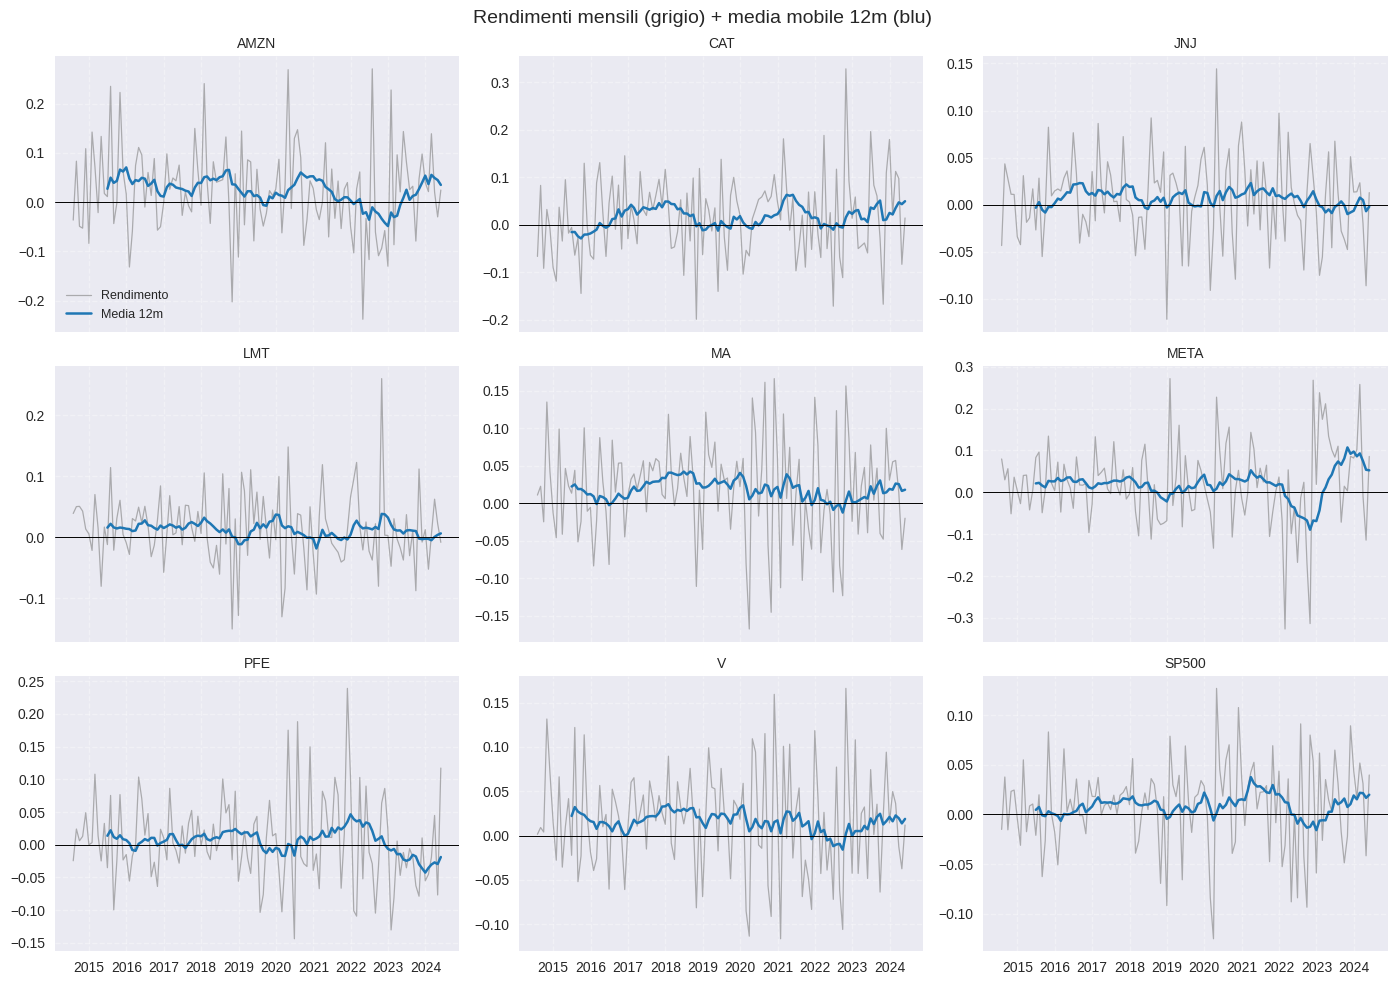

In [9]:
# Heatmap delle correlazioni
corr_m = monthly_returns.corr()
plt.figure(figsize=(8.5, 7))
sns.heatmap(
    corr_m, vmin=-1, vmax=1, cmap="RdYlGn",
    annot=True, fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": .85},
    annot_kws={"fontsize":8}
)
plt.title("Matrice di correlazione (rendimenti mensili)", fontsize=13)
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# Coppie intra-settore
sector_map = {
    "Payments": ["V","MA"],
    "Healthcare": ["JNJ","PFE"],
    "Industrials": ["LMT","CAT"],
    "Tech/Consumer": ["META","AMZN"],
}
pairs_by_sector = []
for _, lst in sector_map.items():
    pairs_by_sector += list(combinations(lst, 2))

for a, b in pairs_by_sector:
    x = monthly_returns[a].dropna()
    y = monthly_returns[b].reindex(x.index).dropna()
    x = x.reindex(y.index)

    slope, intercept, r, p, _ = stats.linregress(x, y)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = intercept + slope * x_line

    plt.figure(figsize=(5.8, 4.6))
    plt.scatter(x, y, s=18, alpha=0.65, color="tab:blue", edgecolors="none")
    plt.plot(x_line, y_line, color="black", lw=1.4)
    plt.axhline(0, color="gray", lw=0.7); plt.axvline(0, color="gray", lw=0.7)
    plt.title(f"{a} vs {b}  (r = {r:.2f})")
    plt.xlabel(a); plt.ylabel(b)
    plt.grid(True, ls="--", alpha=0.4)
    plt.tight_layout(); plt.show()

# Correlazioni rolling
window = 12
for a, b in pairs_by_sector:
    rc = monthly_returns[a].rolling(window).corr(monthly_returns[b])
    plt.figure(figsize=(9.2, 3.8))
    plt.plot(rc.index, rc, label=f"{a}-{b}", color="tab:blue")
    plt.axhline(0.0,  color="gray", ls="--", lw=0.7)
    plt.axhline(0.5,  color="gray", ls=":",  lw=0.7)
    plt.axhline(-0.5, color="gray", ls=":",  lw=0.7)
    plt.title(f"Correlazione rolling {window} mesi: {a} vs {b}")
    plt.ylim(-1, 1); plt.xlabel("Anno"); plt.ylabel("Corr")
    plt.grid(True, ls="--", alpha=0.35); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

# Matrice di varianza/covarianza
cov_matrix = monthly_returns.cov()
var_vector = monthly_returns.var()

mask_diag = np.eye(cov_matrix.shape[0], dtype=bool)
offdiag = cov_matrix.mask(mask_diag)
absmax = np.nanmax(np.abs(offdiag.values))
if not np.isfinite(absmax) or absmax == 0:
    absmax = np.nanmax(np.abs(cov_matrix.values))
# Heatmap
plt.figure(figsize=(8.5, 7))
sns.heatmap(
    cov_matrix, vmin=-absmax, vmax=absmax, center=0,
    cmap="RdYlGn", annot=True, fmt=".5f",
    linewidths=0.5, square=True, cbar_kws={"shrink": .85},
    annot_kws={"fontsize":8}
)
plt.title("Matrice di covarianza (rendimenti mensili)", fontsize=13)
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()


# Rendimenti mensili + media mobile 12m
def plot_monthly_returns_clean(df_returns, title, color="tab:blue", ma_window=12):
    fig, axes = plt.subplots(3, 3, figsize=(14,10), sharex=True)
    axes = axes.flatten()
    cols = df_returns.columns.tolist()
    for i, c in enumerate(cols):
        r = df_returns[c].dropna()
        ma = r.rolling(ma_window).mean()
        axes[i].plot(r.index, r, color="gray", alpha=0.6, lw=0.9, label="Rendimento")
        axes[i].plot(ma.index, ma, color=color, lw=1.8, label=f"Media {ma_window}m")
        axes[i].axhline(0, color='black', lw=0.7)
        axes[i].set_title(c, fontsize=10)
        axes[i].grid(True, ls="--", alpha=0.35)
        if i == 0:
            axes[i].legend(frameon=False, fontsize=9)
    fig.suptitle(title, fontsize=14)
    plt.tight_layout(); plt.show()

plot_monthly_returns_clean(
    monthly_returns,
    "Rendimenti mensili (grigio) + media mobile 12m (blu)"
)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


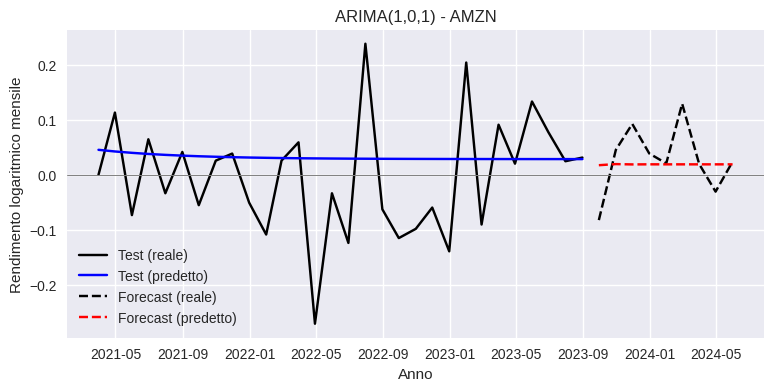

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


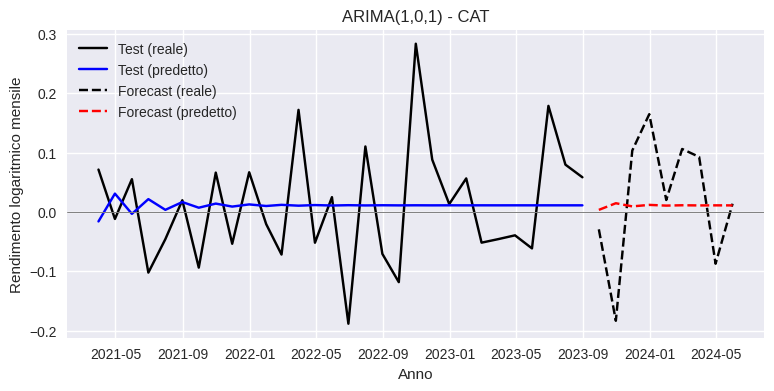

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


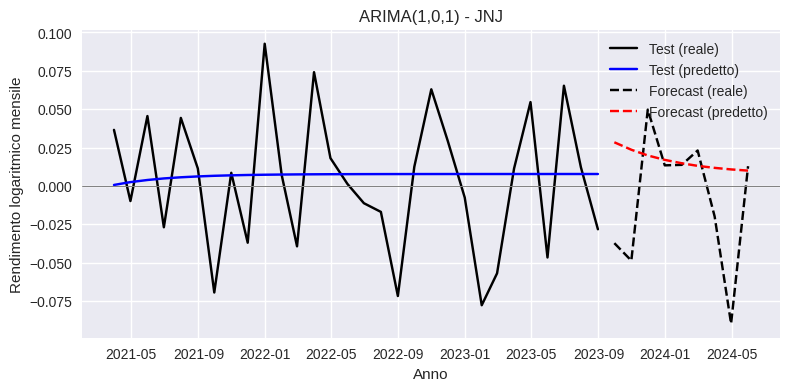

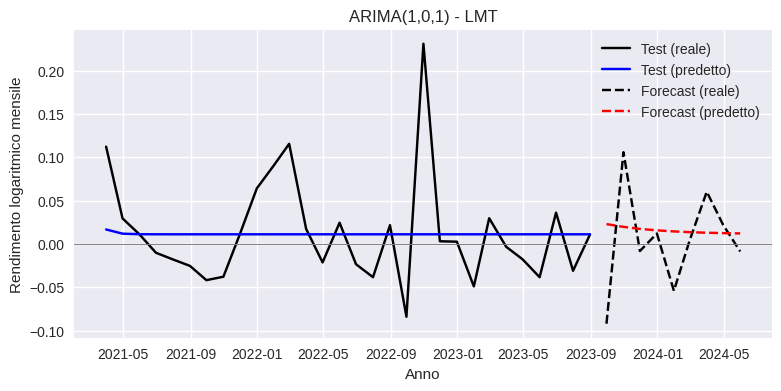

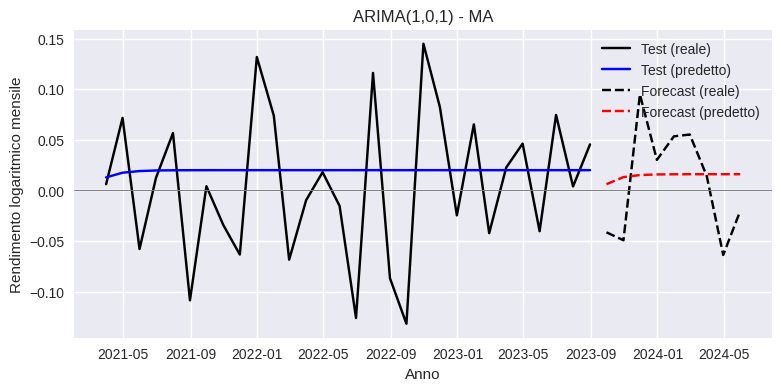

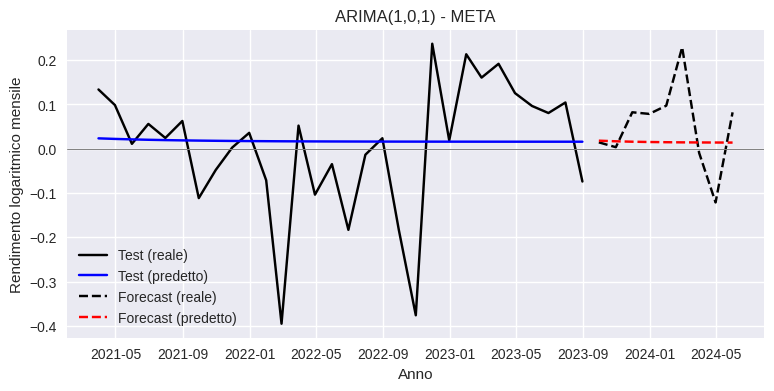

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


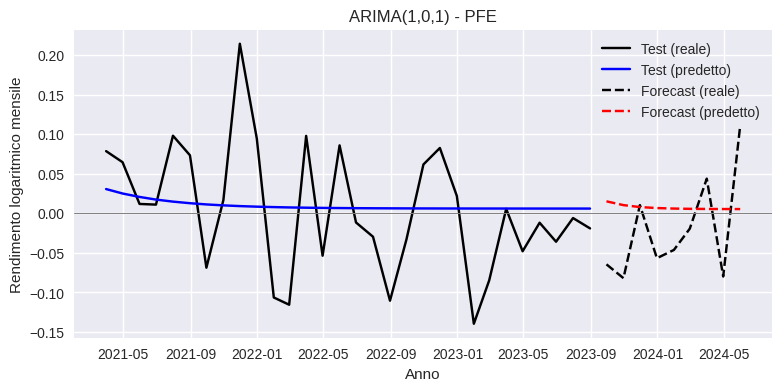

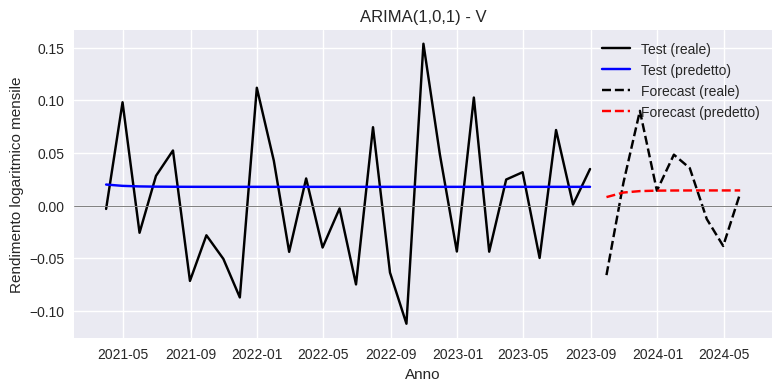

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


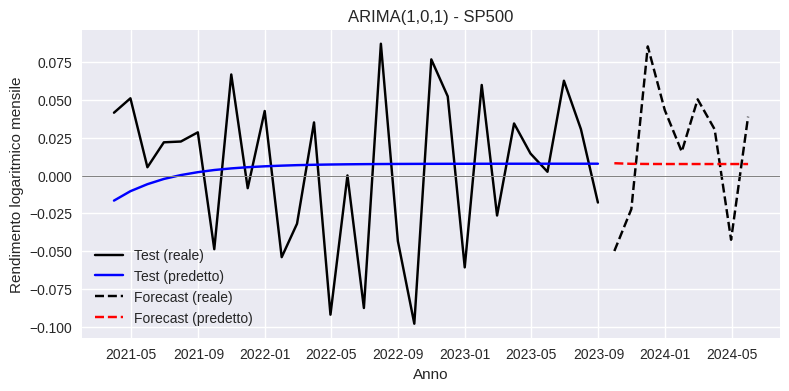

Ticker  RMSE_test  MAE_test  RMSE_forecast  MAE_forecast
0   AMZN     0.1108    0.0856         0.0589        0.0430
1    CAT     0.0991    0.0808         0.1044        0.0851
2    JNJ     0.0447    0.0359         0.0491        0.0353
3    LMT     0.0605    0.0419         0.0566        0.0428
4     MA     0.0737    0.0604         0.0509        0.0443
5   META     0.1474    0.1074         0.0972        0.0746
6    PFE     0.0771    0.0613         0.0684        0.0605
7      V     0.0660    0.0559         0.0428        0.0330
8  SP500     0.0525    0.0448         0.0441        0.0396

In [10]:
###
### FASE 3
###

###Previsioni ARIMA(1,0,1)

# Parametri split
n_train = 80
n_test = 30
n_forecast = 10

results_arima = []

for ticker in monthly_prices.columns:
    series = monthly_prices[ticker].dropna()
    log_ret = np.log(series / series.shift(1)).dropna()

    if len(log_ret) < n_train + n_test + 5:
        print(f"[X] {ticker}: serie troppo corta ({len(log_ret)} mesi) → salto")
        continue

    # split
    train = log_ret.iloc[:n_train]
    test = log_ret.iloc[n_train:n_train+n_test]
    forecast_true = log_ret.iloc[n_train+n_test:n_train+n_test+n_forecast]

    # fit su train
    fitted = ARIMA(train, order=(1,0,1)).fit()

    # pred su test
    pred_test = fitted.forecast(steps=len(test))
    rmse_test = mean_squared_error(test, pred_test) ** 0.5
    mae_test = mean_absolute_error(test, pred_test)

    # refit su train+test e forecast 10 mesi
    fitted_full = ARIMA(log_ret.iloc[:n_train+n_test], order=(1,0,1)).fit()
    pred_forecast = fitted_full.forecast(steps=n_forecast)

    # errori forecast
    n_common = min(len(forecast_true), len(pred_forecast))
    if n_common > 0:
        rmse_forecast = mean_squared_error(forecast_true.iloc[:n_common],
                                           pred_forecast[:n_common]) ** 0.5
        mae_forecast = mean_absolute_error(forecast_true.iloc[:n_common],
                                           pred_forecast[:n_common])
    else:
        rmse_forecast, mae_forecast = np.nan, np.nan

    # salvo
    results_arima.append({
        "Ticker": ticker,
        "RMSE_test": rmse_test,
        "MAE_test": mae_test,
        "RMSE_forecast": rmse_forecast,
        "MAE_forecast": mae_forecast
    })

    # Plot
    plt.figure(figsize=(9,4))
    plt.plot(test.index, test, label="Test (reale)", color="black")
    plt.plot(test.index, pred_test, label="Test (predetto)", color="blue")

    if n_common > 0:
        plt.plot(forecast_true.index[:n_common], forecast_true.iloc[:n_common],
                 label="Forecast (reale)", color="black", linestyle="--")
        plt.plot(forecast_true.index[:n_common], pred_forecast[:n_common],
                 label="Forecast (predetto)", color="red", linestyle="--")

    plt.title(f"ARIMA(1,0,1) - {ticker}")
    plt.xlabel("Anno"); plt.ylabel("Rendimento logaritmico mensile")
    plt.axhline(0, color="gray", lw=0.7)
    plt.legend(); plt.grid(True); plt.show()

# tabella finale
df_results = pd.DataFrame(results_arima)
df_results = df_results[["Ticker","RMSE_test","MAE_test","RMSE_forecast","MAE_forecast"]]
df_results.to_csv("arima_errori.csv", index=False)
display(df_results.round(4))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

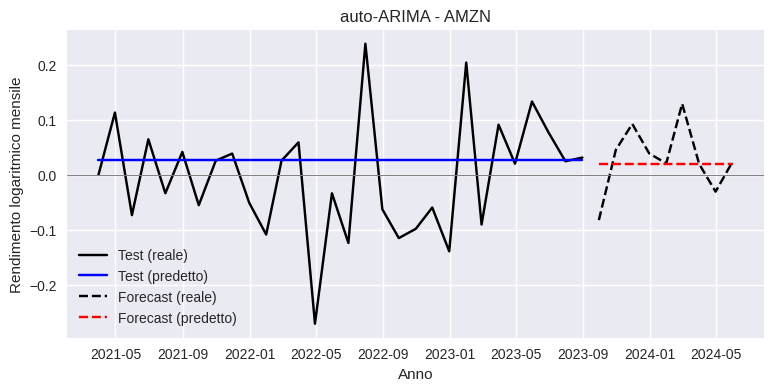

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

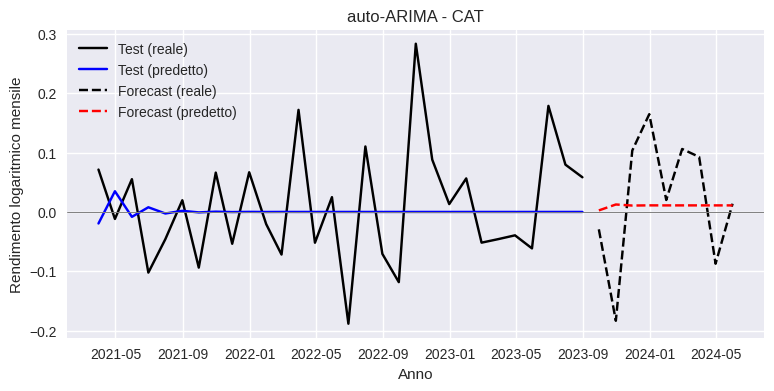

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

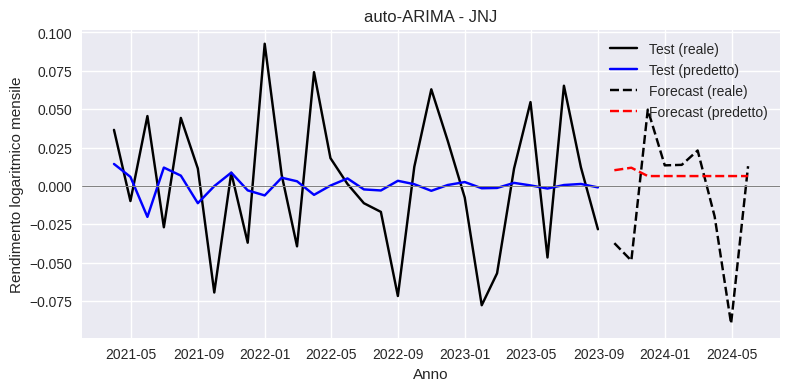

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

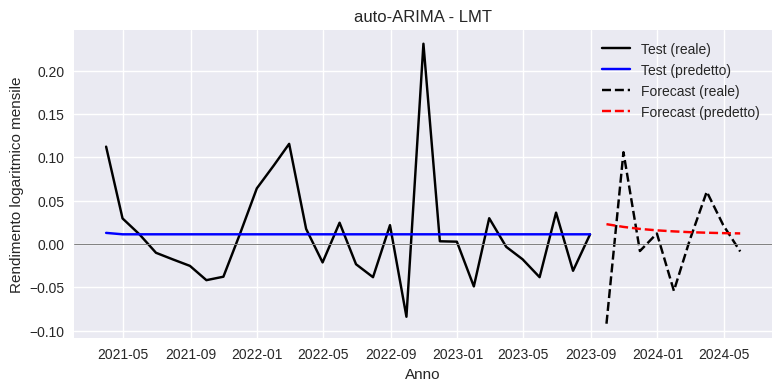

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

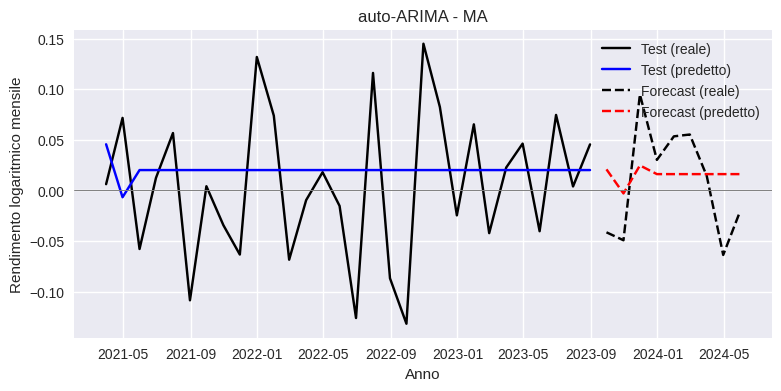

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

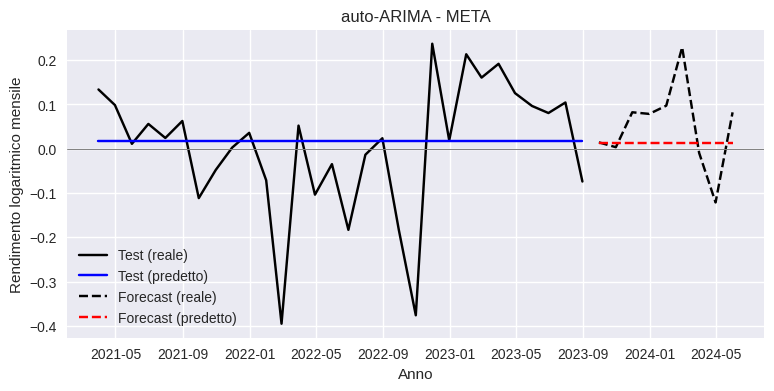

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

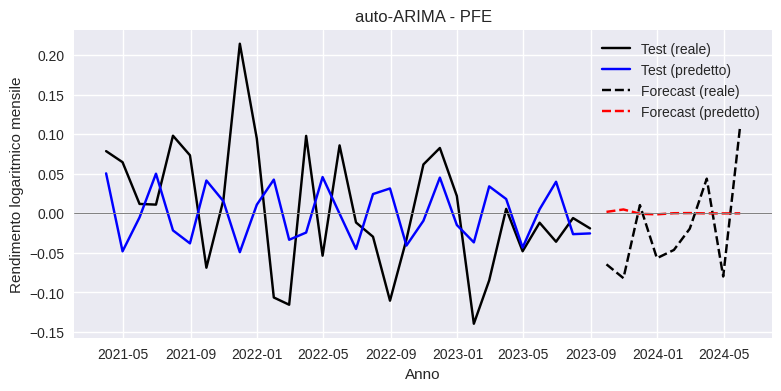

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

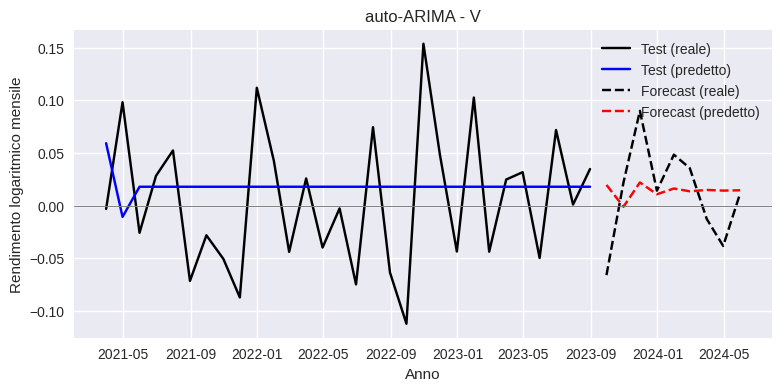

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

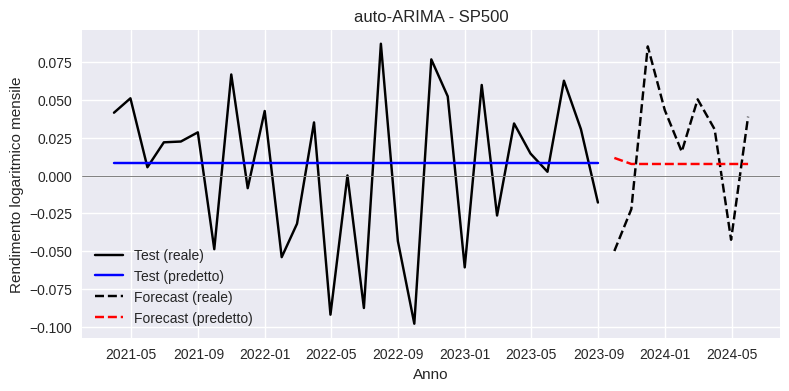

Ticker      Order  RMSE_test  MAE_test  RMSE_forecast  MAE_forecast
0   AMZN  (0, 0, 0)     0.1097    0.0847         0.0593        0.0433
1    CAT  (2, 0, 0)     0.0997    0.0813         0.1040        0.0847
2    JNJ  (4, 0, 3)     0.0459    0.0370         0.0450        0.0346
3    LMT  (0, 0, 1)     0.0607    0.0420         0.0566        0.0428
4     MA  (0, 0, 2)     0.0748    0.0623         0.0492        0.0431
5   META  (0, 0, 0)     0.1475    0.1077         0.0978        0.0746
6    PFE  (2, 0, 3)     0.0922    0.0722         0.0652        0.0578
7      V  (0, 0, 2)     0.0682    0.0582         0.0441        0.0352
8  SP500  (0, 0, 0)     0.0509    0.0425         0.0446        0.0400

In [11]:
### Previsioni con auto-ARIMA

results_auto = []

for ticker in monthly_prices.columns:
    series = monthly_prices[ticker].dropna()
    log_ret = np.log(series / series.shift(1)).dropna()

    if len(log_ret) < n_train + n_test + 5:
        print(f"⚠️ {ticker}: serie troppo corta ({len(log_ret)} mesi) → salto")
        continue

    # split
    train = log_ret.iloc[:n_train]
    test = log_ret.iloc[n_train:n_train+n_test]
    forecast_true = log_ret.iloc[n_train+n_test:n_train+n_test+n_forecast]

    # auto-ARIMA su train
    model = pm.auto_arima(train, seasonal=False, stepwise=True,
                          suppress_warnings=True, max_order=6,
                          error_action='ignore', trace=False)

    # pred su test
    pred_test = model.predict(n_periods=len(test))
    rmse_test = mean_squared_error(test, pred_test) ** 0.5
    mae_test = mean_absolute_error(test, pred_test)

    # refit su train+test e forecast 10 mesi
    model_full = pm.auto_arima(log_ret.iloc[:n_train+n_test], seasonal=False,
                               stepwise=True, suppress_warnings=True,
                               max_order=6, error_action='ignore', trace=False)
    pred_forecast = model_full.predict(n_periods=n_forecast)

    n_common = min(len(forecast_true), len(pred_forecast))
    if n_common > 0:
        rmse_forecast = mean_squared_error(forecast_true.iloc[:n_common],
                                           pred_forecast[:n_common]) ** 0.5
        mae_forecast = mean_absolute_error(forecast_true.iloc[:n_common],
                                           pred_forecast[:n_common])
    else:
        rmse_forecast, mae_forecast = np.nan, np.nan

    results_auto.append({
        "Ticker": ticker,
        "Order": str(model.order),
        "RMSE_test": rmse_test,
        "MAE_test": mae_test,
        "RMSE_forecast": rmse_forecast,
        "MAE_forecast": mae_forecast
    })

    # Plot
    plt.figure(figsize=(9,4))
    plt.plot(test.index, test, label="Test (reale)", color="black")
    plt.plot(test.index, pred_test, label="Test (predetto)", color="blue")
    if n_common > 0:
        plt.plot(forecast_true.index[:n_common], forecast_true.iloc[:n_common],
                 label="Forecast (reale)", color="black", linestyle="--")
        plt.plot(forecast_true.index[:n_common], pred_forecast[:n_common],
                 label="Forecast (predetto)", color="red", linestyle="--")
    plt.title(f"auto-ARIMA - {ticker}")
    plt.xlabel("Anno"); plt.ylabel("Rendimento logaritmico mensile")
    plt.axhline(0, color="gray", lw=0.7)
    plt.legend(); plt.grid(True); plt.show()

# tabella finale
df_auto = pd.DataFrame(results_auto)
df_auto = df_auto[["Ticker","Order","RMSE_test","MAE_test","RMSE_forecast","MAE_forecast"]]
df_auto.to_csv("auto_arima_errori.csv", index=False)
display(df_auto.round(4))

Backtest Mean Reversion — V


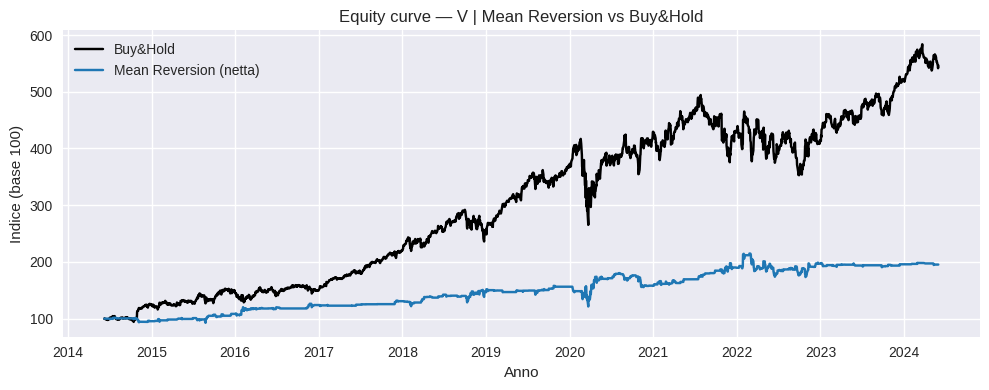

Backtest Mean Reversion — MA


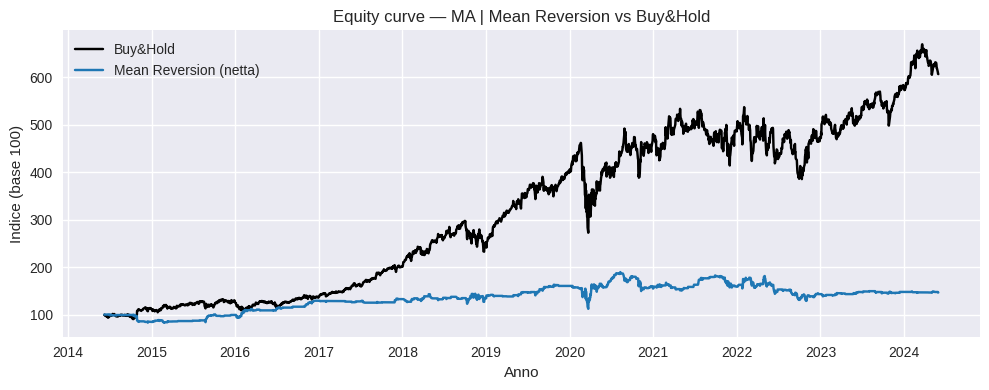

Backtest Mean Reversion — JNJ


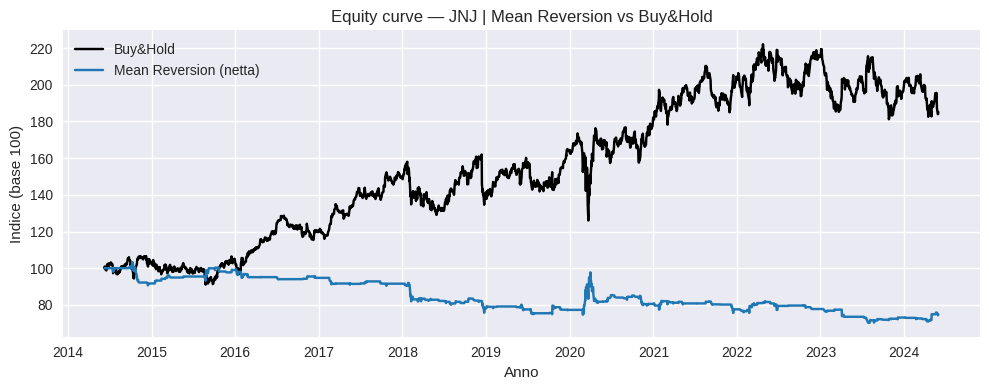

Backtest Mean Reversion — PFE


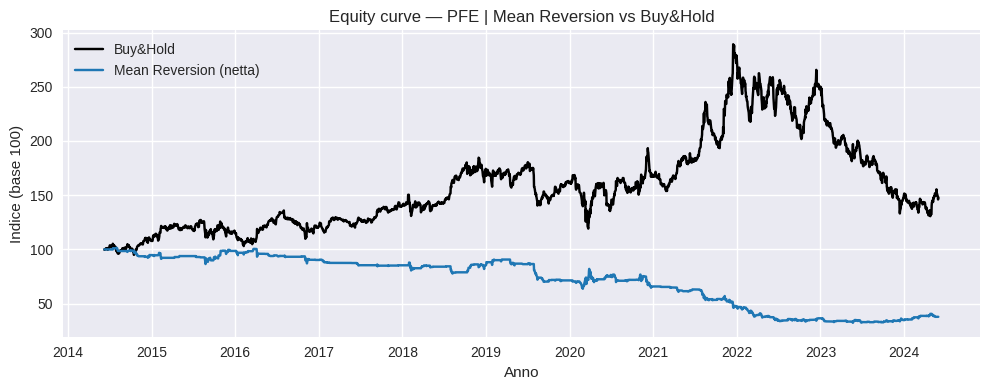

Backtest Mean Reversion — META


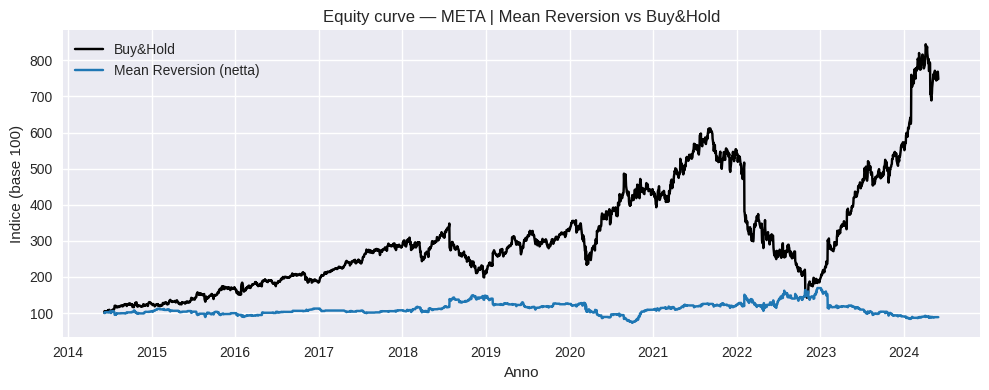

Backtest Mean Reversion — AMZN


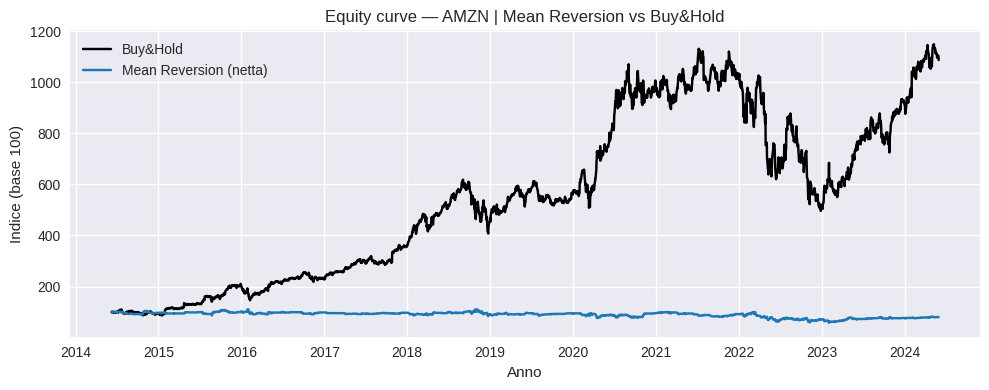

Backtest Mean Reversion — LMT


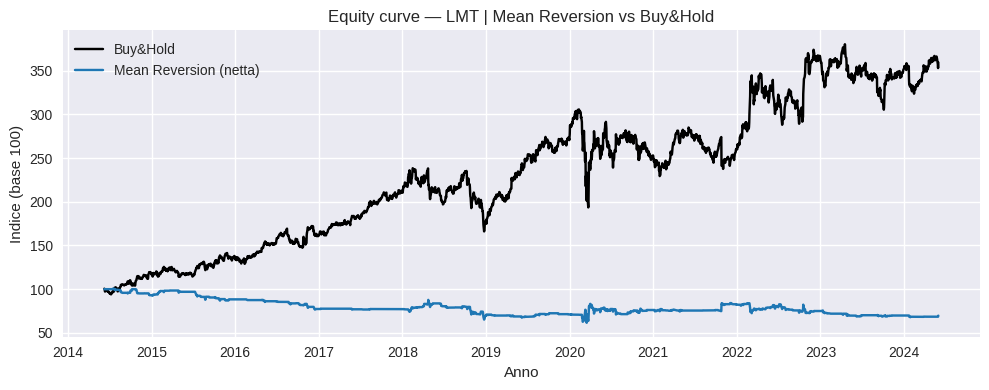

Backtest Mean Reversion — CAT


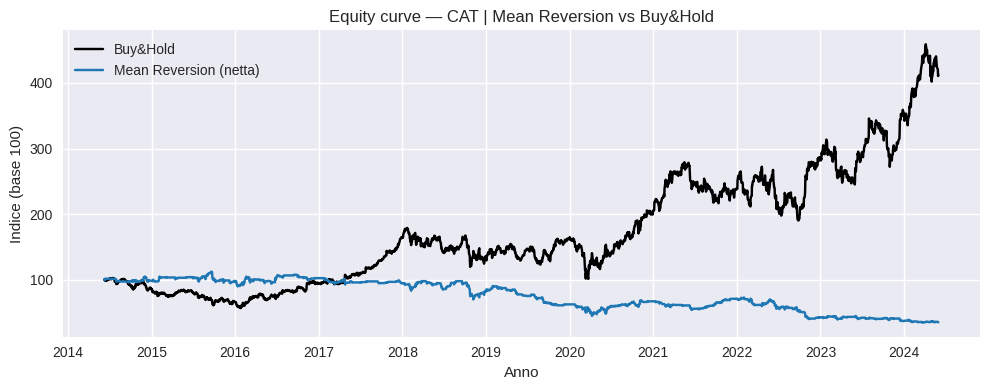

Backtest Mean Reversion — SP500


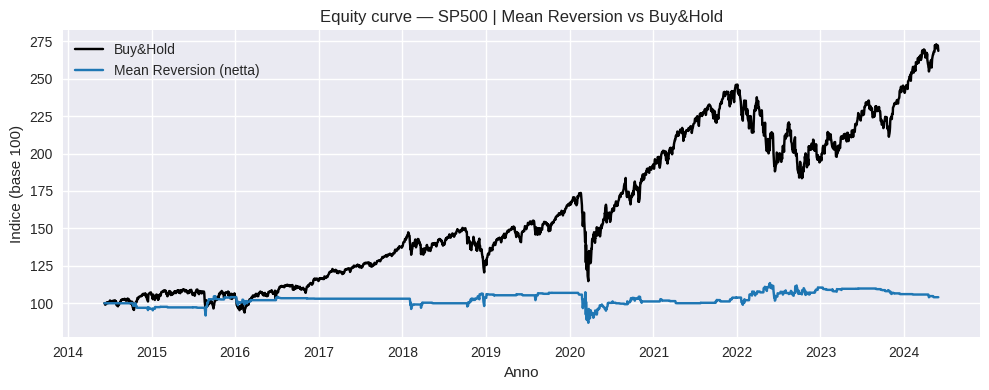

  Ticker  CAGR_BH  Vol_ann_BH  Sharpe_BH  MaxDD_BH  CAGR_MR  Vol_ann_MR  \
0      V   0.1857      0.2451     0.8176   -0.3636   0.0695      0.1702   
1     MA   0.1983      0.2696     0.8057   -0.4100   0.0390      0.1953   
8  SP500   0.1042      0.1775     0.6476   -0.3392   0.0040      0.1130   
4   META   0.2237      0.3739     0.7292   -0.7674  -0.0121      0.2811   
5   AMZN   0.2705      0.3274     0.8946   -0.5615  -0.0220      0.2305   
2    JNJ   0.0637      0.1807     0.4324   -0.2737  -0.0287      0.1044   
6    LMT   0.1369      0.2211     0.6914   -0.3667  -0.0356      0.1516   
3    PFE   0.0402      0.2284     0.2863   -0.5482  -0.0928      0.1494   
7    CAT   0.1526      0.2949     0.6296   -0.4463  -0.0991      0.2050   

   Sharpe_MR  MaxDD_MR  Lookback  Thresh  Tcost  
0     0.4792   -0.2309         5    0.03  0.001  
1     0.2931   -0.3206         5    0.03  0.001  
8     0.0921   -0.1902         5    0.03  0.001  
4     0.0964   -0.5115         5    0.03  0.001  

In [12]:
###
### FASE 4 - Analisi tecnica & Backtesting
###

### Strategia: Mean Reversion 5 giorni (long/short)

# Parametri strategia
LOOKBACK = 5        # giorni per il segnale
THRESH = 0.03       # soglia ipercomprato/ipervenduto (+/-3% su 5 giorni)
TCOST = 0.001       # costo transazione per trade (0.1% = 10 bps)
ANNUALIZE = 252     # giorni di mercato in un anno

def backtest_mr_single(price: pd.Series, lookback=5, thresh=0.03, tcost=0.001):
    """Backtest Mean Reversion long/short con costi"""

    # Robustezza serie prezzi
    px = pd.Series(price).dropna().copy()

    try:
        px.index = pd.to_datetime(px.index)
    except Exception:
        pass
    px = px.sort_index()
    px = px[~px.index.duplicated(keep="last")]

    df = pd.DataFrame({"price": px})
    df["ret"] = df["price"].pct_change()


    df["roll"] = df["price"].pct_change(lookback)

    # Segnale: long se < -thresh, short se > +thresh
    df["signal"] = 0
    df.loc[df["roll"] < -thresh, "signal"] = 1
    df.loc[df["roll"] > +thresh, "signal"] = -1

    # Posizione effettiva (ritardata 1 giorno per look-ahead)
    df["pos"] = df["signal"].shift(1).fillna(0)

    # Rendimento Buy&Hold
    df["ret_bh"] = df["ret"]

    # Rendimento strategia lordo
    df["ret_strat"] = df["pos"] * df["ret"]

    # Costi transazione
    df["turnover"] = df["pos"].diff().abs().fillna(0)
    df["cost"] = df["turnover"] * tcost

    # Rendimento strategia netto
    df["ret_strat_net"] = df["ret_strat"] - df["cost"]

    # Drop NaN iniziali
    df = df.dropna()

    # Metriche
    def metrics(ret_series):
        n_days = ret_series.shape[0]
        if n_days == 0:
            return {"CAGR": np.nan, "Vol_ann": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
        cum = (1 + ret_series).prod()

        if cum <= 0:
            cagr = np.nan
        else:
            cagr = cum ** (ANNUALIZE / n_days) - 1
        vol_ann = ret_series.std(ddof=1) * np.sqrt(ANNUALIZE)
        sharpe = (ret_series.mean() * ANNUALIZE) / vol_ann if vol_ann > 0 else np.nan
        equity = (1 + ret_series).cumprod()
        dd = equity / equity.cummax() - 1.0
        maxdd = dd.min()
        return {"CAGR": cagr, "Vol_ann": vol_ann, "Sharpe": sharpe, "MaxDD": maxdd}

    m_bh  = metrics(df["ret_bh"])
    m_str = metrics(df["ret_strat_net"])

    return df, m_bh, m_str


### Loop su titoli e benchmark

#Selezione automatica del benchmark più comune disponibile
_bench_candidates = ["^GSPC", "SP500", "SPX", "^SPX", "^INX"]
benchmark_key = next((c for c in _bench_candidates if c in all_data.columns), None)

to_eval = list(tickers)
if benchmark_key is not None:
    to_eval.append(benchmark_key)

rows = []

for tk in to_eval:
    print(f"Backtest Mean Reversion — {tk}")
    if tk not in all_data.columns:
        print(f"⚠️ {tk}: non presente in all_data → salto")
        continue

    px = all_data[tk].dropna()
    bt, m_bh, m_str = backtest_mr_single(px, LOOKBACK, THRESH, TCOST)

    #Equity curve base 100
    eq_bh  = (1 + bt["ret_bh"]).cumprod() * 100
    eq_str = (1 + bt["ret_strat_net"]).cumprod() * 100

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(eq_bh.index, eq_bh, label="Buy&Hold", color="black")
    plt.plot(eq_str.index, eq_str, label="Mean Reversion (netta)", color="tab:blue")
    plt.title(f"Equity curve — {tk} | Mean Reversion vs Buy&Hold")
    plt.ylabel("Indice (base 100)")
    plt.xlabel("Anno")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Tabella metriche
    rows.append({
        "Ticker": tk,
        "CAGR_BH": m_bh["CAGR"],
        "Vol_ann_BH": m_bh["Vol_ann"],
        "Sharpe_BH": m_bh["Sharpe"],
        "MaxDD_BH": m_bh["MaxDD"],
        "CAGR_MR": m_str["CAGR"],
        "Vol_ann_MR": m_str["Vol_ann"],
        "Sharpe_MR": m_str["Sharpe"],
        "MaxDD_MR": m_str["MaxDD"],
        "Lookback": LOOKBACK,
        "Thresh": THRESH,
        "Tcost": TCOST
    })

df_bt_mr = pd.DataFrame(rows).sort_values(by="CAGR_MR", ascending=False)
print(df_bt_mr.round(4))

df_bt_mr.to_csv("backtest_MR_results.csv", index=False)

Backtest SMA 50/200 — V


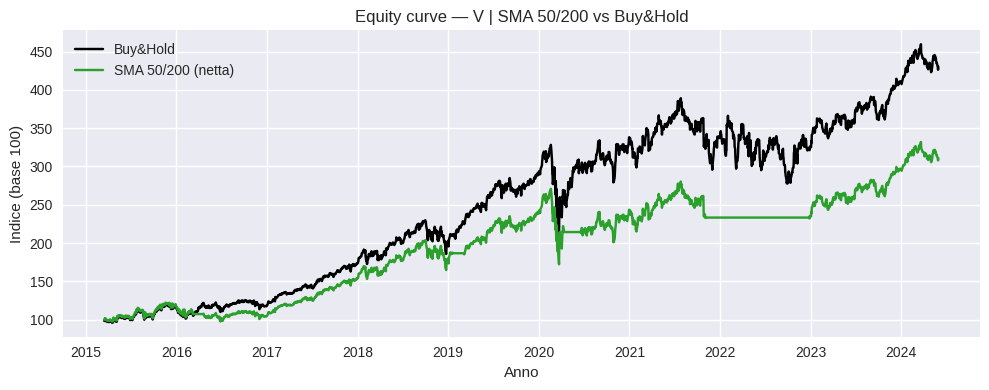

Backtest SMA 50/200 — MA


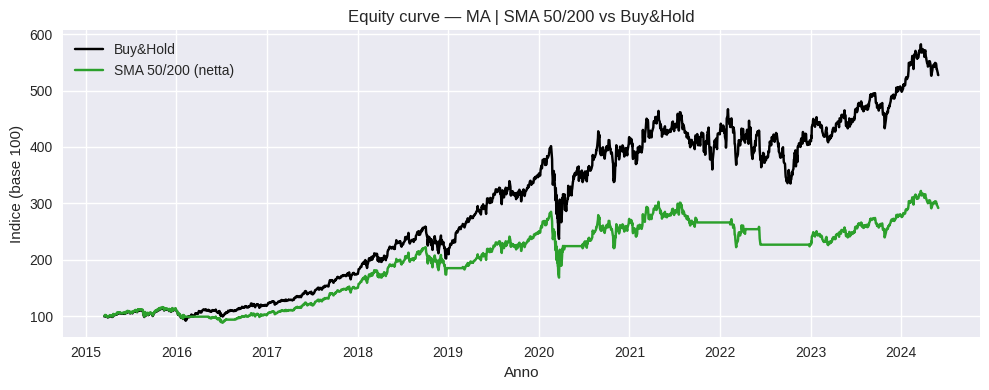

Backtest SMA 50/200 — JNJ


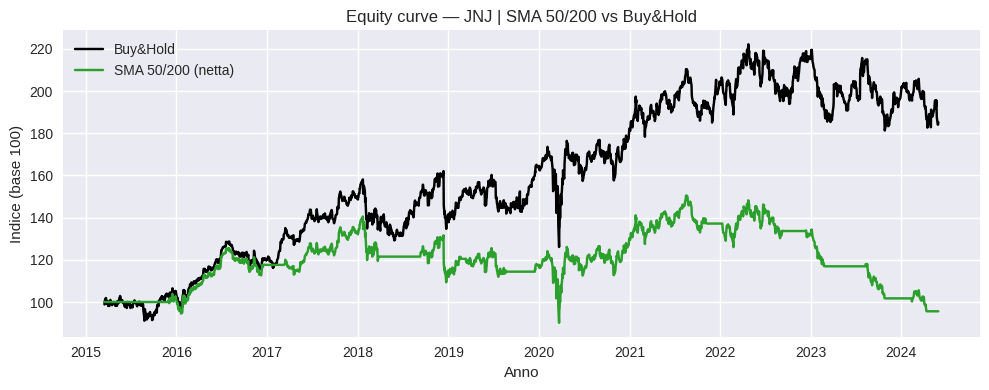

Backtest SMA 50/200 — PFE


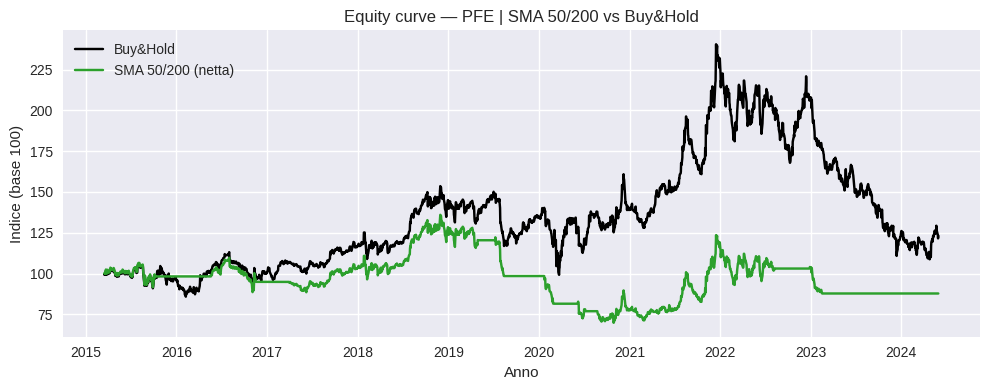

Backtest SMA 50/200 — META


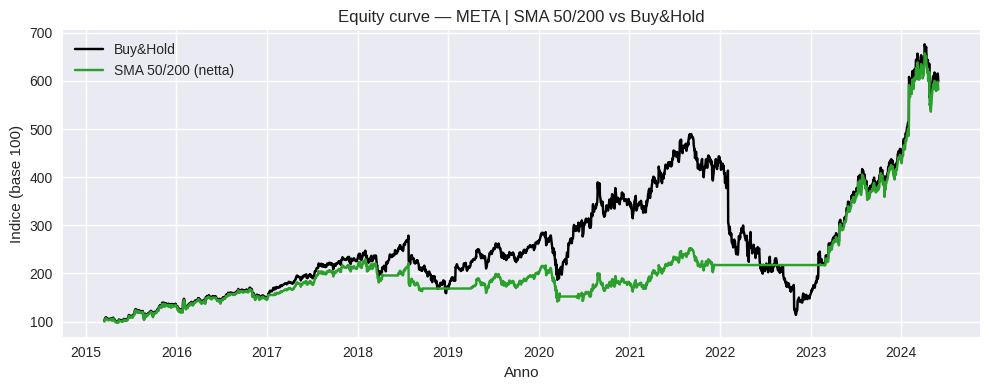

Backtest SMA 50/200 — AMZN


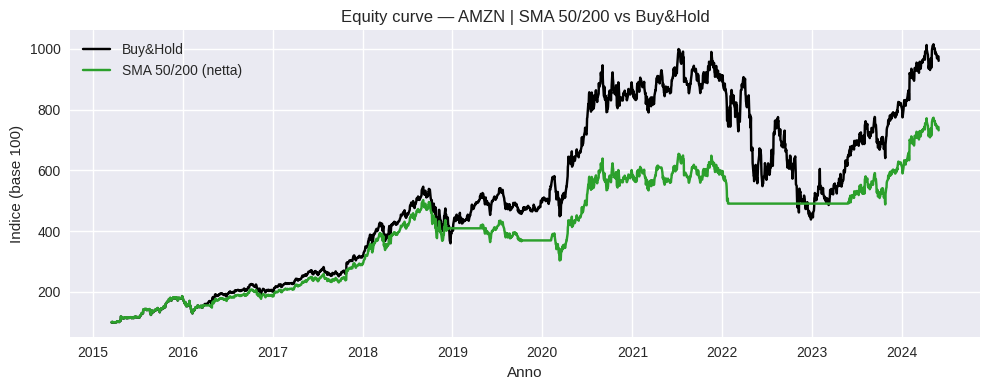

Backtest SMA 50/200 — LMT


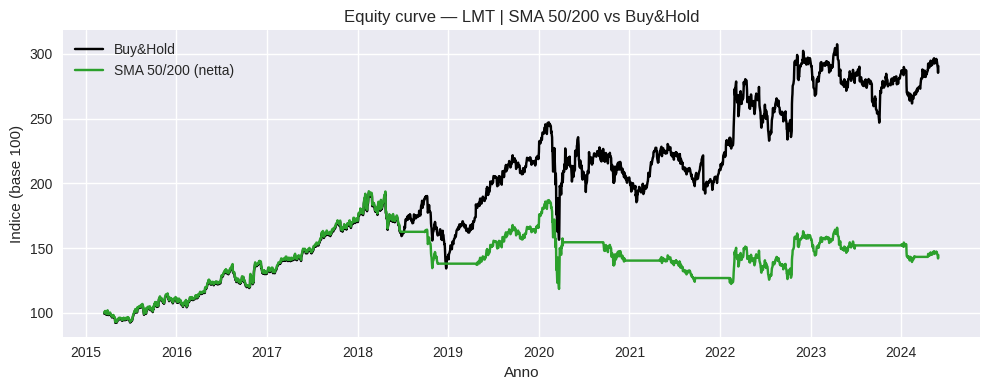

Backtest SMA 50/200 — CAT


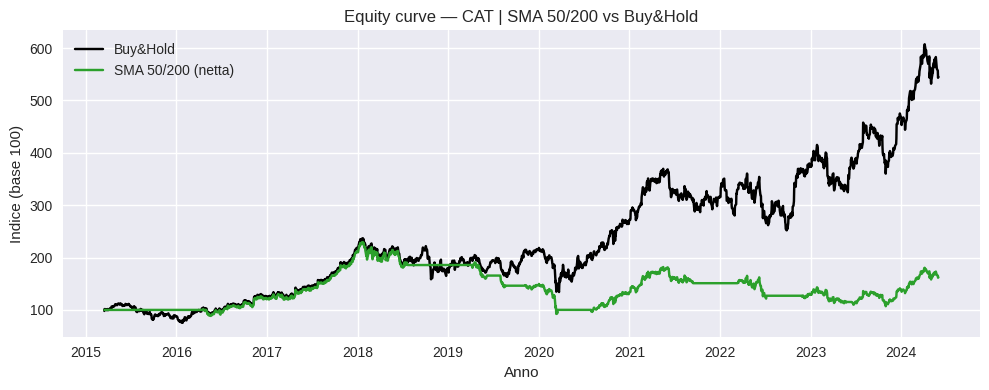

Backtest SMA 50/200 — SP500


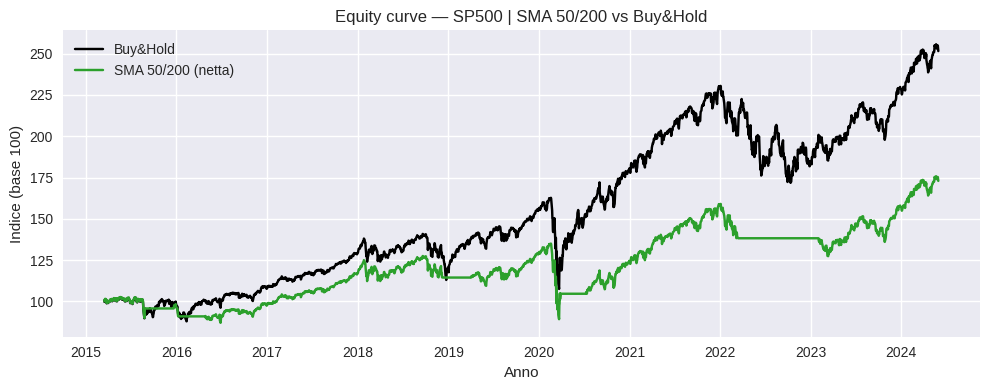

  Ticker  CAGR_BH  Vol_ann_BH  Sharpe_BH  MaxDD_BH  CAGR_SMA  Vol_ann_SMA  \
5   AMZN   0.2788      0.3281     0.9133   -0.5615    0.2416       0.2621   
4   META   0.2148      0.3820     0.7028   -0.7674    0.2111       0.2809   
0      V   0.1719      0.2480     0.7635   -0.3636    0.1312       0.2150   
1     MA   0.1982      0.2729     0.7988   -0.4100    0.1234       0.2364   
8  SP500   0.1055      0.1813     0.6442   -0.3392    0.0614       0.1466   
7    CAT   0.2025      0.2998     0.7654   -0.4336    0.0539       0.2181   
6    LMT   0.1229      0.2252     0.6279   -0.3667    0.0409       0.1920   
2    JNJ   0.0693      0.1822     0.4590   -0.2737   -0.0049       0.1563   
3    PFE   0.0229      0.2338     0.2136   -0.5482   -0.0141       0.1739   

   Sharpe_SMA  MaxDD_SMA  Fast  Slow  Tcost  
5      0.9561    -0.3961    50   200  0.001  
4      0.8222    -0.3827    50   200  0.001  
0      0.6810    -0.3636    50   200  0.001  
1      0.6103    -0.4100    50   200  0.001  

In [17]:
###Strategia: SMA 50/200 (long-only)

# Parametri strategia
FAST = 50          # media mobile breve
SLOW = 200         # media mobile lunga
TCOST = 0.001
ANNUALIZE = 252

def backtest_sma_single(price: pd.Series, fast=50, slow=200, tcost=0.001):
    """Backtest SMA long-only con costi (robusto a indice/NaN)"""

    px = pd.Series(price).dropna().copy()
    try:
        px.index = pd.to_datetime(px.index)
    except Exception:
        pass
    px = px.sort_index()
    px = px[~px.index.duplicated(keep="last")]

    # Se non ci sono abbastanza dati per la SMA lenta, ritorna NaN
    if px.shape[0] < slow + 5:
        return pd.DataFrame(index=px.index), \
               {"CAGR": np.nan, "Vol_ann": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}, \
               {"CAGR": np.nan, "Vol_ann": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}

    df = pd.DataFrame({"price": px})
    df["ret"] = df["price"].pct_change()

    # Calcolo medie mobili
    df["SMA_fast"] = df["price"].rolling(fast).mean()
    df["SMA_slow"] = df["price"].rolling(slow).mean()

    # Segnale: long se SMA_fast > SMA_slow
    df["signal"] = (df["SMA_fast"] > df["SMA_slow"]).astype(int)

    df["pos"] = df["signal"].shift(1).fillna(0)

    df["ret_bh"] = df["ret"]

    df["ret_strat"] = df["pos"] * df["ret"]

    df["turnover"] = df["pos"].diff().abs().fillna(0)
    df["cost"] = df["turnover"] * tcost

    df["ret_strat_net"] = df["ret_strat"] - df["cost"]

    df = df.dropna()

    # Metriche
    def metrics(ret_series):
        n_days = ret_series.shape[0]
        if n_days == 0:
            return {"CAGR": np.nan, "Vol_ann": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
        cum = (1 + ret_series).prod()
        cagr = (cum ** (ANNUALIZE / n_days) - 1) if cum > 0 else np.nan
        vol_ann = ret_series.std(ddof=1) * np.sqrt(ANNUALIZE)
        sharpe = (ret_series.mean() * ANNUALIZE) / vol_ann if vol_ann > 0 else np.nan
        equity = (1 + ret_series).cumprod()
        dd = equity / equity.cummax() - 1.0
        maxdd = dd.min()
        return {"CAGR": cagr, "Vol_ann": vol_ann, "Sharpe": sharpe, "MaxDD": maxdd}

    m_bh  = metrics(df["ret_bh"])
    m_str = metrics(df["ret_strat_net"])

    return df, m_bh, m_str


### Loop su titoli e benchmark

try:
    _ = to_eval  # verifica esistenza
except NameError:
    _bench_candidates = ["^GSPC", "SP500", "SPX", "^SPX", "^INX"]
    benchmark_key = next((c for c in all_data.columns if c in _bench_candidates), None)
    to_eval = list(tickers)
    if benchmark_key is not None:
        to_eval.append(benchmark_key)

rows_sma = []

for tk in to_eval:
    print(f"Backtest SMA 50/200 — {tk}")

    if tk not in all_data.columns:
        print(f"[X] {tk}: non presente in all_data → salto")
        continue

    px = all_data[tk].dropna()
    bt, m_bh, m_str = backtest_sma_single(px, FAST, SLOW, TCOST)

    if bt.empty:
        print(f"[X] {tk}: dati insufficienti per SMA {SLOW} → salto")
        continue

    eq_bh  = (1 + bt["ret_bh"]).cumprod() * 100
    eq_str = (1 + bt["ret_strat_net"]).cumprod() * 100

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(eq_bh.index, eq_bh, label="Buy&Hold", color="black")
    plt.plot(eq_str.index, eq_str, label="SMA 50/200 (netta)", color="tab:green")
    plt.title(f"Equity curve — {tk} | SMA 50/200 vs Buy&Hold")
    plt.ylabel("Indice (base 100)")
    plt.xlabel("Anno")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Tabella metriche
    rows_sma.append({
        "Ticker": tk,
        "CAGR_BH": m_bh["CAGR"],
        "Vol_ann_BH": m_bh["Vol_ann"],
        "Sharpe_BH": m_bh["Sharpe"],
        "MaxDD_BH": m_bh["MaxDD"],
        "CAGR_SMA": m_str["CAGR"],
        "Vol_ann_SMA": m_str["Vol_ann"],
        "Sharpe_SMA": m_str["Sharpe"],
        "MaxDD_SMA": m_str["MaxDD"],
        "Fast": FAST,
        "Slow": SLOW,
        "Tcost": TCOST
    })

df_bt_sma = pd.DataFrame(rows_sma).sort_values(by="CAGR_SMA", ascending=False)
print(df_bt_sma.round(4))


df_bt_sma.to_csv("backtest_SMA_results.csv", index=False)

Backtest Mean Reversion long-only - V


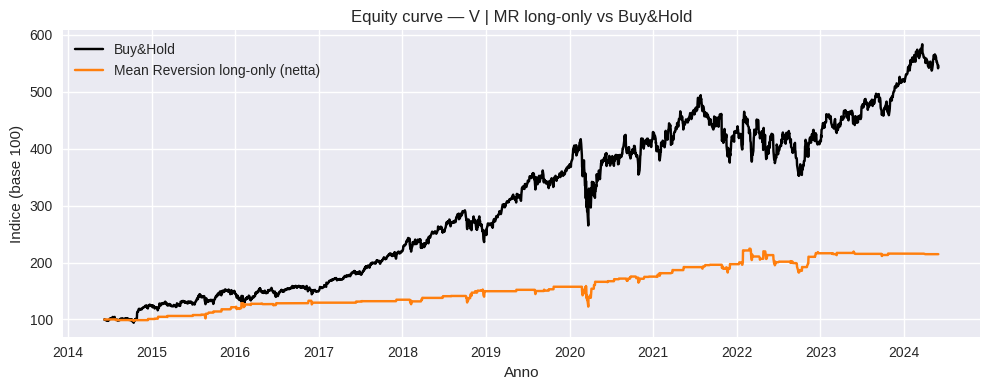

Backtest Mean Reversion long-only - MA


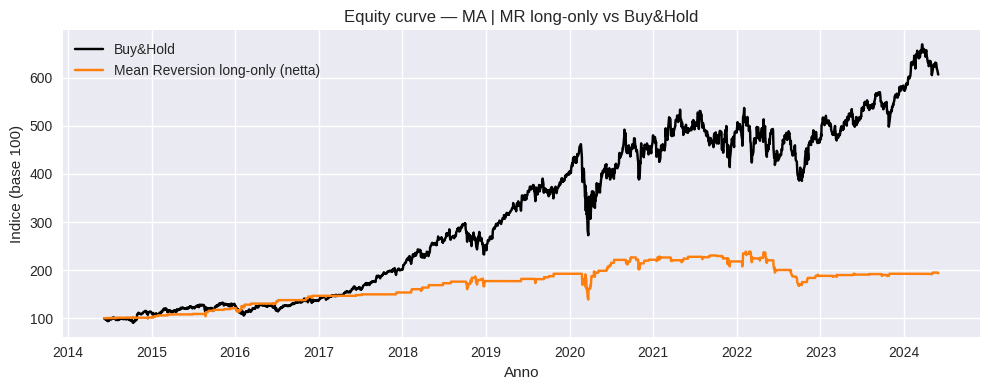

Backtest Mean Reversion long-only - JNJ


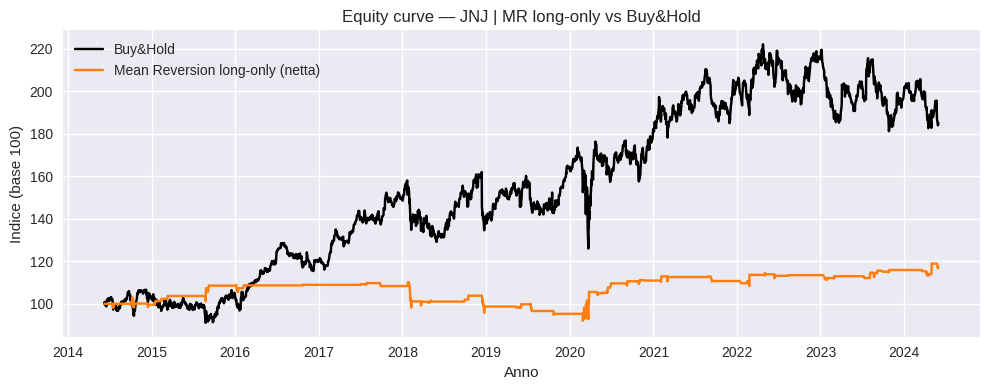

Backtest Mean Reversion long-only - PFE


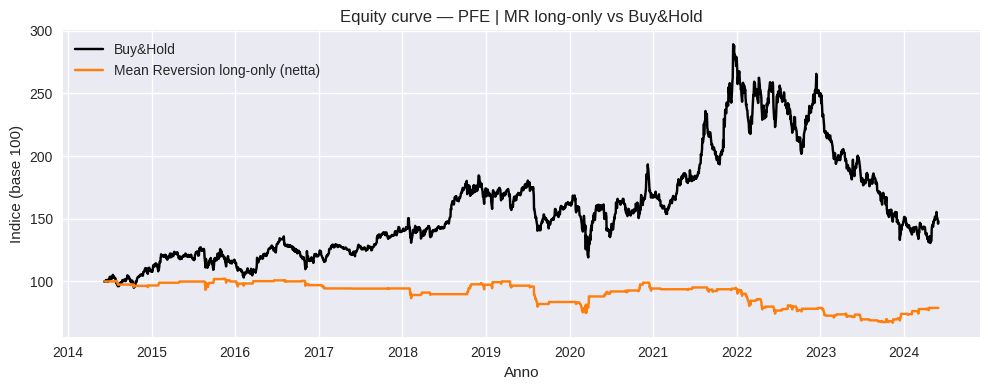

Backtest Mean Reversion long-only - META


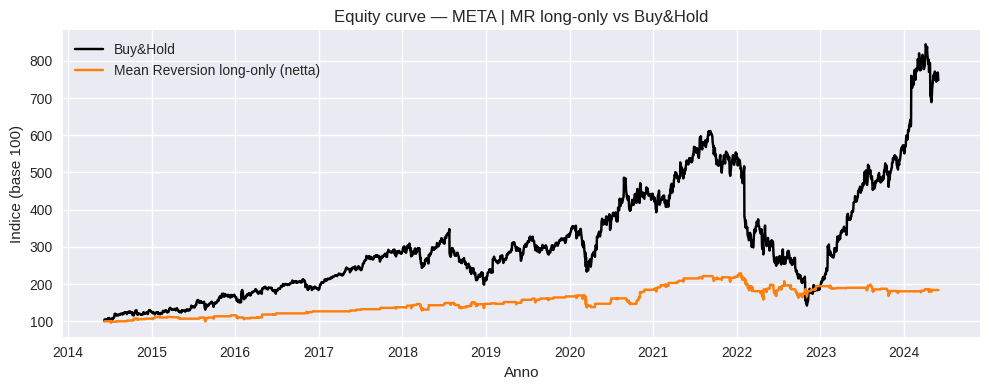

Backtest Mean Reversion long-only - AMZN


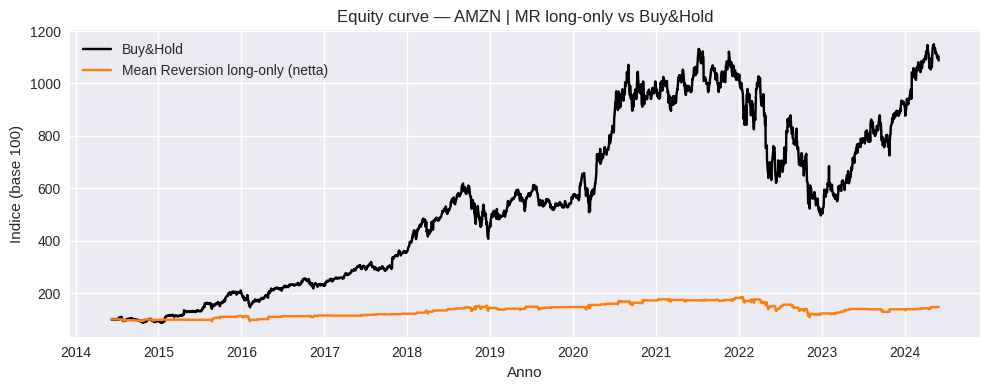

Backtest Mean Reversion long-only - LMT


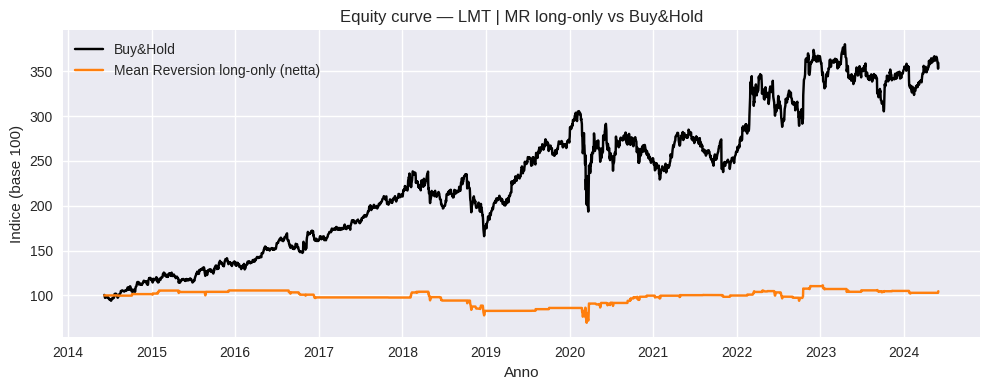

Backtest Mean Reversion long-only - CAT


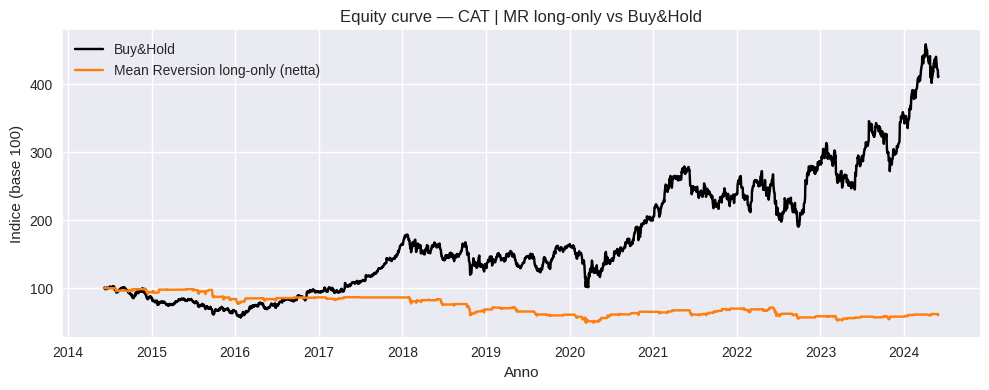

Backtest Mean Reversion long-only - SP500


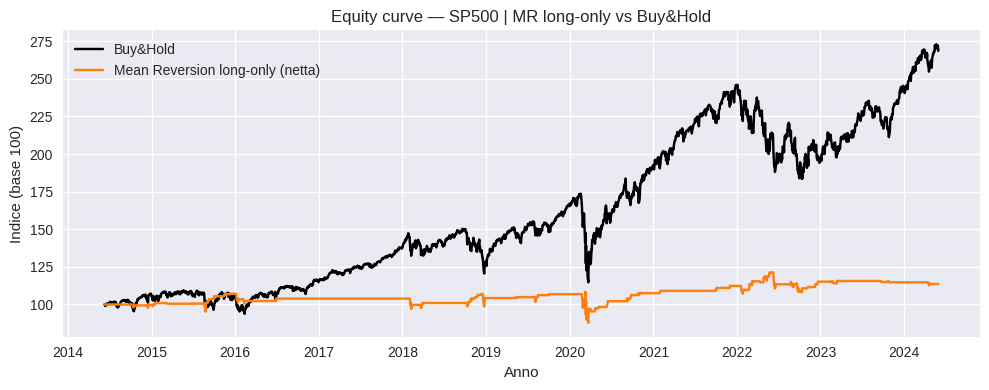

  Ticker  CAGR_BH  Vol_ann_BH  Sharpe_BH  MaxDD_BH  CAGR_MR_Long  \
0      V   0.1857      0.2451     0.8176   -0.3636        0.0797   
1     MA   0.1983      0.2696     0.8057   -0.4100        0.0683   
4   META   0.2237      0.3739     0.7292   -0.7674        0.0632   
5   AMZN   0.2705      0.3274     0.8946   -0.5615        0.0397   
2    JNJ   0.0637      0.1807     0.4324   -0.2737        0.0163   
8  SP500   0.1042      0.1775     0.6476   -0.3392        0.0129   
6    LMT   0.1369      0.2211     0.6914   -0.3667        0.0046   
3    PFE   0.0402      0.2284     0.2863   -0.5482       -0.0235   
7    CAT   0.1526      0.2949     0.6296   -0.4463       -0.0488   

   Vol_ann_MR_Long  Sharpe_MR_Long  MaxDD_MR_Long  Lookback  Thresh  Tcost  
0           0.1455          0.5991        -0.2280         5    0.03  0.001  
1           0.1615          0.4893        -0.2998         5    0.03  0.001  
4           0.1904          0.4165        -0.3098         5    0.03  0.001  
5          

In [18]:
### Strategia: Mean Reversion 5 giorni (long-only)


LOOKBACK = 5
THRESH   = 0.03
TCOST    = 0.001
ANNUALIZE = 252

def backtest_mr_long_only(price: pd.Series, lookback=5, thresh=0.03, tcost=0.001):
    """Backtest Mean Reversion long-only (long/flat) con costi, robusto a input/NaN."""

    px = pd.Series(price).dropna().copy()
    try:
        px.index = pd.to_datetime(px.index)
    except Exception:
        pass
    px = px.sort_index()
    px = px[~px.index.duplicated(keep="last")]

    # Dati minimi per avere un rolling sensato
    if px.shape[0] < lookback + 5:
        return pd.DataFrame(index=px.index), \
               {"CAGR": np.nan, "Vol_ann": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}, \
               {"CAGR": np.nan, "Vol_ann": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}

    df = pd.DataFrame({"price": px})
    df["ret"] = df["price"].pct_change()

    df["roll"] = df["price"].pct_change(lookback)

    # Segnale: long se < -thresh, flat altrimenti
    df["signal"] = 0
    df.loc[df["roll"] < -thresh, "signal"] = 1

    df["pos"] = df["signal"].shift(1).fillna(0)

    df["ret_bh"] = df["ret"]

    df["ret_strat"] = df["pos"] * df["ret"]

    df["turnover"] = df["pos"].diff().abs().fillna(0)
    df["cost"] = df["turnover"] * tcost

    df["ret_strat_net"] = df["ret_strat"] - df["cost"]

    df = df.dropna()

    # Metriche
    def metrics(ret_series):
        n_days = ret_series.shape[0]
        if n_days == 0:
            return {"CAGR": np.nan, "Vol_ann": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
        cum = (1 + ret_series).prod()
        cagr = (cum ** (ANNUALIZE / n_days) - 1) if cum > 0 else np.nan
        vol_ann = ret_series.std(ddof=1) * np.sqrt(ANNUALIZE)
        sharpe = (ret_series.mean() * ANNUALIZE) / vol_ann if vol_ann > 0 else np.nan
        equity = (1 + ret_series).cumprod()
        dd = equity / equity.cummax() - 1.0
        maxdd = dd.min()
        return {"CAGR": cagr, "Vol_ann": vol_ann, "Sharpe": sharpe, "MaxDD": maxdd}

    m_bh  = metrics(df["ret_bh"])
    m_str = metrics(df["ret_strat_net"])

    return df, m_bh, m_str

### Loop su titoli e benchmark
try:
    _ = to_eval
except NameError:
    _bench_candidates = ["^GSPC", "SP500", "SPX", "^SPX", "^INX"]
    benchmark_key = next((c for c in _bench_candidates if c in all_data.columns), None)
    to_eval = list(tickers)
    if benchmark_key is not None:
        to_eval.append(benchmark_key)

rows_mr_long = []

for tk in to_eval:
    print(f"Backtest Mean Reversion long-only - {tk}")

    if tk not in all_data.columns:
        print(f"[X] {tk}: non presente in all_data => salto")
        continue

    px = all_data[tk].dropna()
    bt, m_bh, m_str = backtest_mr_long_only(px, LOOKBACK, THRESH, TCOST)

    if bt.empty:
        print(f"[X] {tk}: dati insufficienti per MR lookback={LOOKBACK} → salto")
        continue

    # Equity curve base 100
    eq_bh  = (1 + bt["ret_bh"]).cumprod() * 100
    eq_str = (1 + bt["ret_strat_net"]).cumprod() * 100

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(eq_bh.index, eq_bh, label="Buy&Hold", color="black")
    plt.plot(eq_str.index, eq_str, label="Mean Reversion long-only (netta)", color="tab:orange")
    plt.title(f"Equity curve — {tk} | MR long-only vs Buy&Hold")
    plt.ylabel("Indice (base 100)")
    plt.xlabel("Anno")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Tabella metriche
    rows_mr_long.append({
        "Ticker": tk,
        "CAGR_BH": m_bh["CAGR"],
        "Vol_ann_BH": m_bh["Vol_ann"],
        "Sharpe_BH": m_bh["Sharpe"],
        "MaxDD_BH": m_bh["MaxDD"],
        "CAGR_MR_Long": m_str["CAGR"],
        "Vol_ann_MR_Long": m_str["Vol_ann"],
        "Sharpe_MR_Long": m_str["Sharpe"],
        "MaxDD_MR_Long": m_str["MaxDD"],
        "Lookback": LOOKBACK,
        "Thresh": THRESH,
        "Tcost": TCOST
    })

df_bt_mr_long = pd.DataFrame(rows_mr_long).sort_values(by="CAGR_MR_Long", ascending=False)
print(df_bt_mr_long.round(4))

df_bt_mr_long.to_csv("backtest_MR_long_only_results.csv", index=False)

Random Forest — V


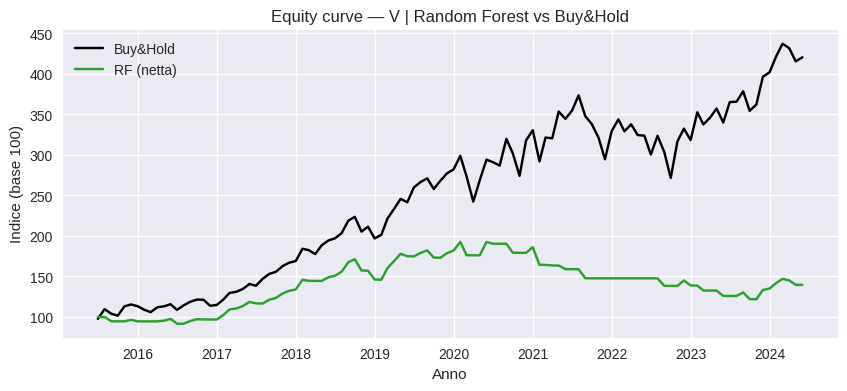

Random Forest — MA


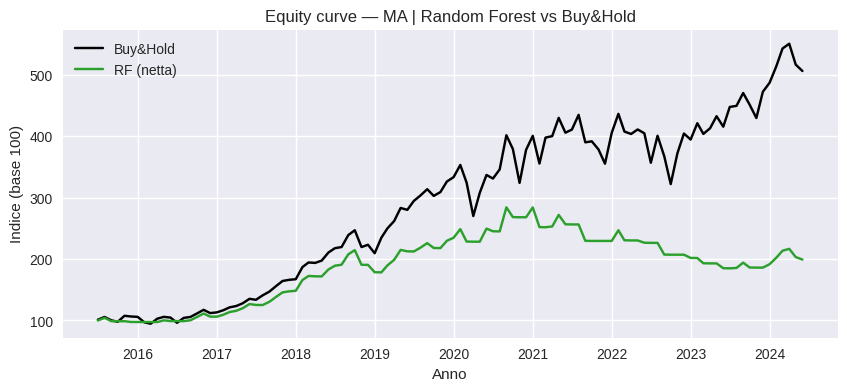

Random Forest — JNJ


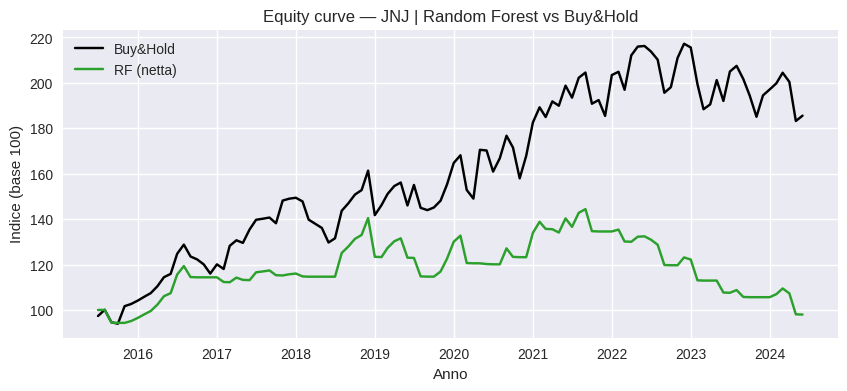

Random Forest — PFE


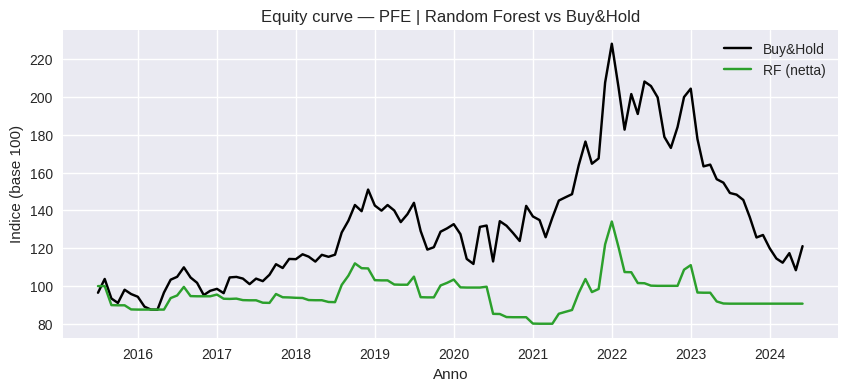

Random Forest — META


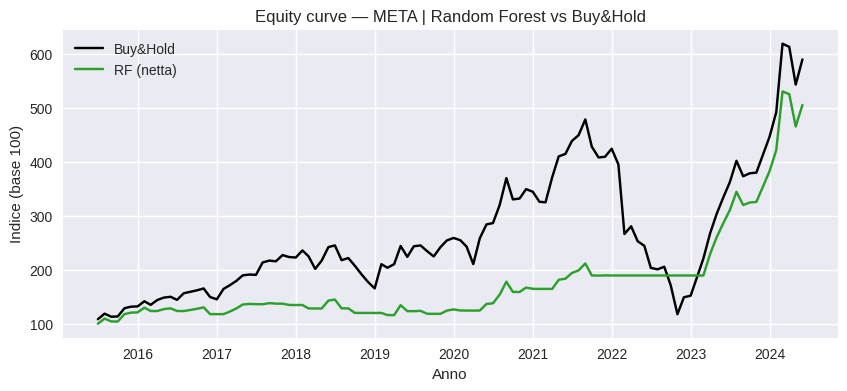

Random Forest — AMZN


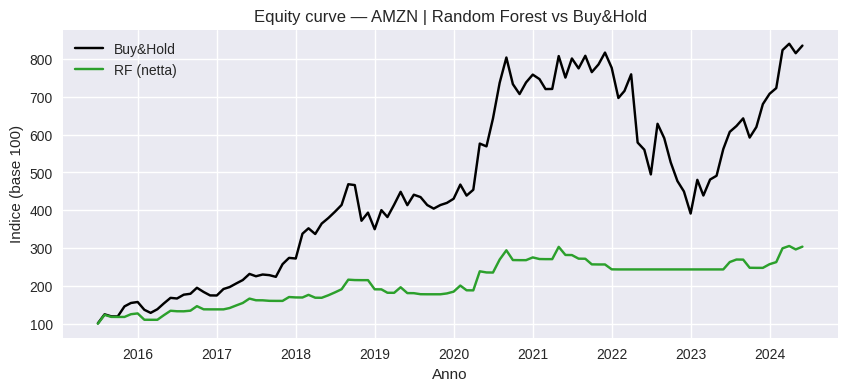

Random Forest — LMT


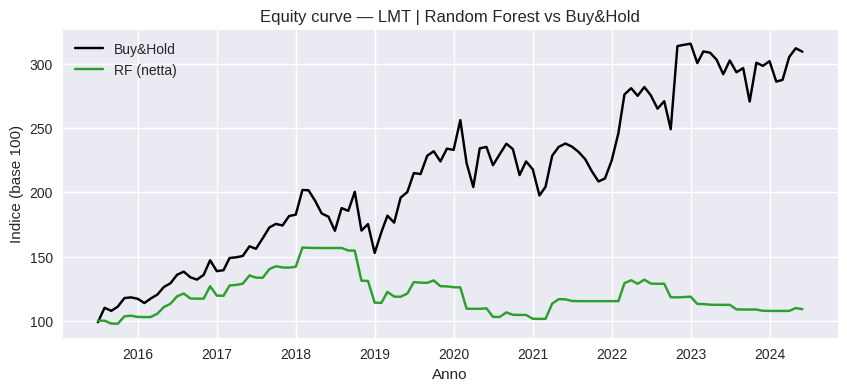

Random Forest — CAT


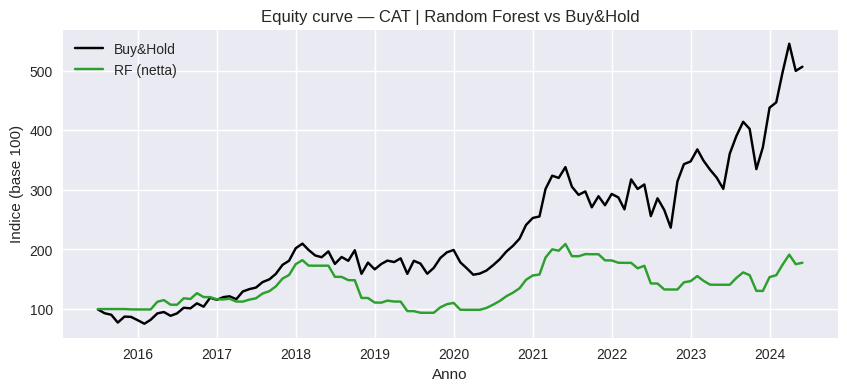

Random Forest — SP500


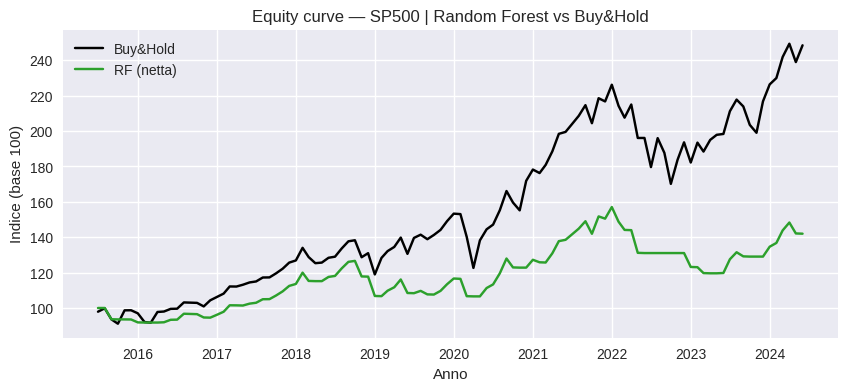

  Ticker  CAGR_BH  Vol_ann_BH  Sharpe_BH  MaxDD_BH  CAGR_RF  Vol_ann_RF  \
0      V   0.1730      0.2061     0.8802   -0.2729   0.0377      0.1287   
1     MA   0.1975      0.2340     0.8918   -0.2619   0.0796      0.1535   
2    JNJ   0.0711      0.1593     0.5113   -0.1567  -0.0023      0.1152   
3    PFE   0.0215      0.2338     0.2040   -0.5247  -0.0108      0.1611   
4   META   0.2181      0.3509     0.7439   -0.7544   0.1974      0.2112   
5   AMZN   0.2660      0.3152     0.9078   -0.5210   0.1314      0.1982   
6    LMT   0.1338      0.2122     0.6974   -0.2431   0.0096      0.1348   
7    CAT   0.1976      0.3016     0.7492   -0.3005   0.0660      0.2173   
8  SP500   0.1064      0.1584     0.7200   -0.2477   0.0397      0.1081   

   Sharpe_RF  MaxDD_RF  Lookback  Tcost  
0     0.3522   -0.3674         3  0.001  
1     0.5761   -0.3493         3  0.001  
2     0.0382   -0.3215         3  0.001  
3     0.0114   -0.3236         3  0.001  
4     0.9591   -0.1991         3  0.001

In [19]:
### FASE 4d — Strategia ML con Random Forest + indicatori tecnici (long-only)

LOOKBACK_RF = 3
TCOST = 0.001
ANNUALIZE = 12
n_train_rf = 70
n_test_rf = 30

def backtest_rf_single(returns: pd.Series, prices: pd.Series, lookback=3, tcost=0.001):
    """Backtest strategia ML (Random Forest) con costi e indicatori tecnici"""

    df = pd.DataFrame({"ret": returns.dropna(), "price": prices.dropna()})
    df = df.dropna()

    ### Indicatori
    df["rsi"] = ta.rsi(df["price"], length=6)        # RSI (6 mesi)
    df["sma_12"] = ta.sma(df["price"], length=12)    # media mobile annuale
    df["sma_gap"] = (df["price"] - df["sma_12"]) / df["sma_12"]
    df["vol_3m"] = df["ret"].rolling(3).std()
    df["mom_3m"] = df["price"].pct_change(3)

    for i in range(1, lookback+1):
        df[f"lag{i}"] = df["ret"].shift(i)

    df["target"] = (df["ret"] > 0).astype(int)
    df = df.dropna()

    if len(df) < (n_train_rf + n_test_rf):
        print(f"⚠️ Dati insufficienti per addestrare RF dopo feature engineering ({len(df)} campioni)")
        return None, None, None


    ### Train/Test split
    X = df[["rsi","sma_gap","vol_3m","mom_3m"] + [f"lag{i}" for i in range(1, lookback+1)]]
    y = df["target"]
    X_train, X_test = X.iloc[:n_train_rf], X.iloc[n_train_rf:n_train_rf+n_test_rf]
    y_train, y_test = y.iloc[:n_train_rf], y.iloc[n_train_rf:n_train_rf+n_test_rf]

    # Random Forest
    rf = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)

    # Predizioni e posizioni (long-only: 1 = long, 0 = flat)
    df["pred"] = rf.predict(X)
    df["pos"] = df["pred"].shift(1).replace({0:0,1:1}).fillna(0)

    # Rendimento strategia netto
    df["ret_strat"] = df["pos"] * df["ret"]
    df["turnover"] = df["pos"].diff().abs().fillna(0)
    df["cost"] = df["turnover"] * tcost
    df["ret_strat_net"] = df["ret_strat"] - df["cost"]

    # Metriche
    def metrics(ret_series):
        n_months = len(ret_series)
        cum = (1 + ret_series).prod()
        cagr = cum ** (12/n_months) - 1
        vol_ann = ret_series.std(ddof=1) * np.sqrt(12)
        sharpe = (ret_series.mean()*12)/vol_ann if vol_ann>0 else np.nan
        equity = (1+ret_series).cumprod()
        dd = equity / equity.cummax() - 1
        maxdd = dd.min()
        return {"CAGR": cagr, "Vol_ann": vol_ann, "Sharpe": sharpe, "MaxDD": maxdd}

    m_bh = metrics(df["ret"])
    m_rf = metrics(df["ret_strat_net"])

    return df, m_bh, m_rf


# Loop su titoli e benchmark
rows_rf = []
for tk in list(tickers) + ["SP500"]:
    print(f"Random Forest — {tk}")
    ret = monthly_returns[tk].dropna()
    px = monthly_prices[tk].dropna()

    bt, m_bh, m_rf = backtest_rf_single(ret, px, LOOKBACK_RF, TCOST)

    if bt is None:
        continue

    eq_bh  = (1+bt["ret"]).cumprod()*100
    eq_str = (1+bt["ret_strat_net"]).cumprod()*100

    plt.figure(figsize=(10,4))
    plt.plot(eq_bh.index, eq_bh, label="Buy&Hold", color="black")
    plt.plot(eq_str.index, eq_str, label="RF (netta)", color="tab:green")
    plt.title(f"Equity curve — {tk} | Random Forest vs Buy&Hold")
    plt.ylabel("Indice (base 100)")
    plt.xlabel("Anno")
    plt.grid(True); plt.legend(); plt.show()

    rows_rf.append({
        "Ticker": tk,
        "CAGR_BH": m_bh["CAGR"],
        "Vol_ann_BH": m_bh["Vol_ann"],
        "Sharpe_BH": m_bh["Sharpe"],
        "MaxDD_BH": m_bh["MaxDD"],
        "CAGR_RF": m_rf["CAGR"],
        "Vol_ann_RF": m_rf["Vol_ann"],
        "Sharpe_RF": m_rf["Sharpe"],
        "MaxDD_RF": m_rf["MaxDD"],
        "Lookback": LOOKBACK_RF,
        "Tcost": TCOST
    })

df_bt_rf = pd.DataFrame(rows_rf)
df_bt_rf.to_csv("backtest_RF_results.csv", index=False)
print(df_bt_rf.round(4))


In [20]:
# Confronto CAGR (%)

# CAGR quattro strategie e Buy&Hold in unico DataFrame
df_cagr = pd.DataFrame({
    "Buy&Hold": df_bt_mr.set_index("Ticker")["CAGR_BH"],
    "MeanRev L&S": df_bt_mr.set_index("Ticker")["CAGR_MR"],
    "MeanRev L": df_bt_mr_long.set_index("Ticker")["CAGR_MR_Long"],
    "SMA 50/200": df_bt_sma.set_index("Ticker")["CAGR_SMA"],
    "Random Forest": df_bt_rf.set_index("Ticker")["CAGR_RF"]
})

df_cagr = df_cagr * 100
print(df_cagr.round(2))


        Buy&Hold  MeanRev L&S  MeanRev L  SMA 50/200  Random Forest
Ticker                                                             
AMZN       27.05        -2.20       3.97       24.16          13.14
CAT        15.26        -9.91      -4.88        5.39           6.60
JNJ         6.37        -2.87       1.63       -0.49          -0.23
LMT        13.69        -3.56       0.46        4.09           0.96
MA         19.83         3.90       6.83       12.34           7.96
META       22.37        -1.21       6.32       21.11          19.74
PFE         4.02        -9.28      -2.35       -1.41          -1.08
SP500      10.42         0.40       1.29        6.14           3.97
V          18.57         6.95       7.97       13.12           3.77


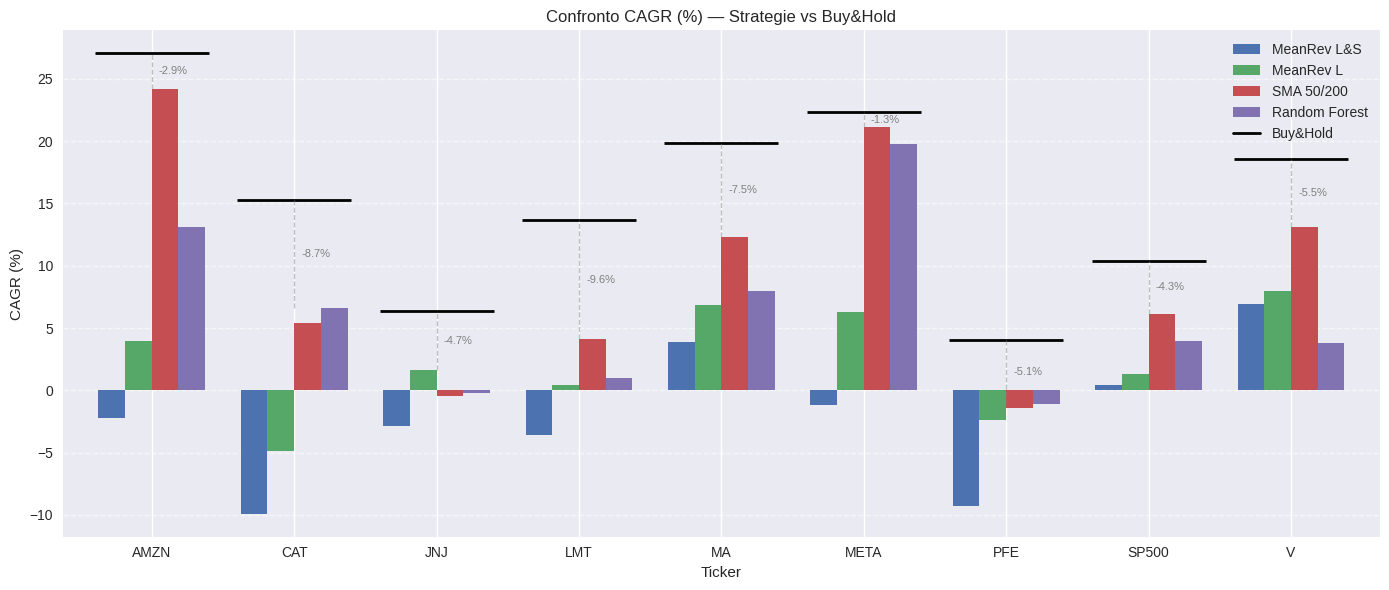

In [21]:
### Grafico confronto CAGR (%)


df_plot = df_cagr.rename(columns={
    "MeanRev L&S": "MeanRev L&S",
    "MeanRev L": "MeanRev L",
    "SMA 50/200": "SMA 50/200",
    "Random Forest": "Random Forest"
})

# Plot barre
fig, ax = plt.subplots(figsize=(14,6))
df_plot[["MeanRev L&S","MeanRev L","SMA 50/200","Random Forest"]].plot(
    kind="bar", ax=ax, width=0.75
)

# Segmenti Buy&Hold
for i, (ticker, row) in enumerate(df_plot.iterrows()):
    bh = row["Buy&Hold"]
    ax.hlines(y=bh, xmin=i-0.4, xmax=i+0.4, colors="black", linewidth=2, label="_nolegend_")

    strat_vals = row[["MeanRev L&S","MeanRev L","SMA 50/200","Random Forest"]]
    closest_name = (strat_vals - bh).abs().idxmin()
    closest_val = strat_vals[closest_name]

    y_min, y_max = sorted([bh, closest_val])
    ax.vlines(x=i, ymin=y_min, ymax=y_max, colors="gray", linestyles="dashed", alpha=0.5, linewidth=1)
    ax.text(i+0.05, (y_min+y_max)/2, f"{(closest_val-bh):+.1f}%",
            ha="left", va="center", fontsize=8, color="gray")

# Buy&Hold legenda
from matplotlib.lines import Line2D
handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], color="black", lw=2))
labels.append("Buy&Hold")
ax.legend(handles, labels)

ax.set_title("Confronto CAGR (%) — Strategie vs Buy&Hold")
ax.set_ylabel("CAGR (%)")
ax.set_xticklabels(df_plot.index, rotation=0)
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


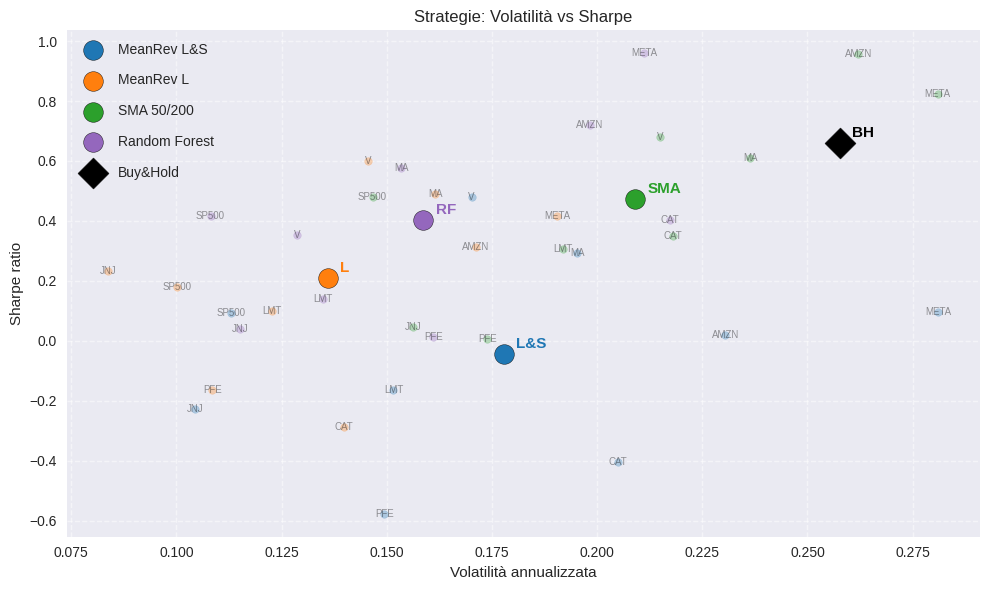

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

for i, row in df_bt_mr.iterrows():
    ax.scatter(row["Vol_ann_MR"], row["Sharpe_MR"],
               color="tab:blue", s=30, alpha=0.3)
    ax.text(row["Vol_ann_MR"], row["Sharpe_MR"], row["Ticker"],
            fontsize=7, alpha=0.4, color="black", ha="center", va="center")

for i, row in df_bt_mr_long.iterrows():
    ax.scatter(row["Vol_ann_MR_Long"], row["Sharpe_MR_Long"],
               color="tab:orange", s=30, alpha=0.3)
    ax.text(row["Vol_ann_MR_Long"], row["Sharpe_MR_Long"], row["Ticker"],
            fontsize=7, alpha=0.4, color="black", ha="center", va="center")

for i, row in df_bt_sma.iterrows():
    ax.scatter(row["Vol_ann_SMA"], row["Sharpe_SMA"],
               color="tab:green", s=30, alpha=0.3)
    ax.text(row["Vol_ann_SMA"], row["Sharpe_SMA"], row["Ticker"],
            fontsize=7, alpha=0.4, color="black", ha="center", va="center")

for i, row in df_bt_rf.iterrows():
    ax.scatter(row["Vol_ann_RF"], row["Sharpe_RF"],
               color="tab:purple", s=30, alpha=0.3)
    ax.text(row["Vol_ann_RF"], row["Sharpe_RF"], row["Ticker"],
            fontsize=7, alpha=0.4, color="black", ha="center", va="center")

mr_ls_mean = (df_bt_mr["Vol_ann_MR"].mean(), df_bt_mr["Sharpe_MR"].mean())
mr_l_mean = (df_bt_mr_long["Vol_ann_MR_Long"].mean(), df_bt_mr_long["Sharpe_MR_Long"].mean())
sma_mean = (df_bt_sma["Vol_ann_SMA"].mean(), df_bt_sma["Sharpe_SMA"].mean())
rf_mean = (df_bt_rf["Vol_ann_RF"].mean(), df_bt_rf["Sharpe_RF"].mean())
bh_vol = df_bt_mr["Vol_ann_BH"].mean()
bh_sharpe = df_bt_mr["Sharpe_BH"].mean()

ax.scatter(*mr_ls_mean, color="tab:blue", s=200, edgecolor="black", zorder=3, label="MeanRev L&S")
ax.scatter(*mr_l_mean, color="tab:orange", s=200, edgecolor="black", zorder=3, label="MeanRev L")
ax.scatter(*sma_mean, color="tab:green", s=200, edgecolor="black", zorder=3, label="SMA 50/200")
ax.scatter(*rf_mean, color="tab:purple", s=200, edgecolor="black", zorder=3, label="Random Forest")
ax.scatter(bh_vol, bh_sharpe, color="black", s=250, marker="D", zorder=3, label="Buy&Hold")

ax.text(mr_ls_mean[0]+0.003, mr_ls_mean[1]+0.02, "L&S", fontsize=11, weight="bold", color="tab:blue")
ax.text(mr_l_mean[0]+0.003, mr_l_mean[1]+0.02, "L", fontsize=11, weight="bold", color="tab:orange")
ax.text(sma_mean[0]+0.003, sma_mean[1]+0.02, "SMA", fontsize=11, weight="bold", color="tab:green")
ax.text(rf_mean[0]+0.003, rf_mean[1]+0.02, "RF", fontsize=11, weight="bold", color="tab:purple")
ax.text(bh_vol+0.003, bh_sharpe+0.02, "BH", fontsize=11, weight="bold", color="black")

ax.set_xlabel("Volatilità annualizzata")
ax.set_ylabel("Sharpe ratio")
ax.set_title("Strategie: Volatilità vs Sharpe")
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(
    loc="upper left",
    frameon=False,
    handletextpad=0.8,
    labelspacing=1.2,
    borderaxespad=0.5
)

plt.tight_layout()
plt.show()


In [23]:
###
### FASE 5 - CAPM & Fattori Fama-French
###


rf_ann = 0.04        # tasso risk-free annuo stimato
mkt_exp = 0.08       # rendimento atteso del mercato

### Stima CAPM (alpha e beta)
results_capm = []

for tk in tickers:
    y = monthly_log_returns[tk].dropna()
    x = monthly_log_returns["SP500"].reindex(y.index)
    df_capm = pd.concat([y, x], axis=1)
    df_capm.columns = ["Ri","Rm"]

    X = sm.add_constant(df_capm["Rm"])
    model = sm.OLS(df_capm["Ri"], X).fit()
    alpha, beta = model.params

  # Rendimento atteso via CAPM
    exp_ret = rf_ann + beta*(mkt_exp - rf_ann)

    results_capm.append({
        "Ticker": tk,
        "Alpha": alpha,
        "Beta": beta,
        "E(R_i)_CAPM": exp_ret
    })

df_capm_res = pd.DataFrame(results_capm).sort_values("Beta", ascending=False)
print("📈 Risultati CAPM (ordinati per Beta):")
print(df_capm_res.round(4))


### Stima Fama-French 3 fattori

# Scarica i dati da Kenneth French Data Library
ff = web.DataReader('F-F_Research_Data_Factors', 'famafrench')[0] / 100
ff.index = ff.index.to_timestamp()  # converte PeriodIndex in Timestamp

# Riallinea i fattori all'indice delle nostre serie
ff_aligned = ff.reindex(monthly_log_returns.index, method="ffill")

results_ff = []

for tk in tickers:
    # Excess return del titolo
    y = (monthly_log_returns[tk] - ff_aligned["RF"]).dropna()
    X = ff_aligned[["Mkt-RF","SMB","HML"]].dropna()

    df_ff = pd.concat([y, X], axis=1, join="inner")
    df_ff.columns = ["Ri","Mkt-RF","SMB","HML"]

    Xreg = sm.add_constant(df_ff[["Mkt-RF","SMB","HML"]])
    model = sm.OLS(df_ff["Ri"], Xreg).fit()

    results_ff.append({
        "Ticker": tk,
        "Alpha": model.params["const"],
        "Beta_MKT": model.params["Mkt-RF"],
        "Beta_SMB": model.params["SMB"],
        "Beta_HML": model.params["HML"],
        "R2": model.rsquared
    })

df_ff_res = pd.DataFrame(results_ff).sort_values("Beta_MKT", ascending=False)
print("\n📊 Esposizione stimata ai fattori Fama-French 3:")
print(df_ff_res.round(4))


📈 Risultati CAPM (ordinati per Beta):
  Ticker   Alpha    Beta  E(R_i)_CAPM
5   AMZN  0.0098  1.2520       0.0901
7    CAT  0.0015  1.2515       0.0901
4   META  0.0071  1.1071       0.0843
1     MA  0.0067  1.0778       0.0831
0      V  0.0066  0.9460       0.0778
3    PFE -0.0022  0.6550       0.0662
6    LMT  0.0061  0.6085       0.0643
2    JNJ  0.0003  0.5718       0.0629

📊 Esposizione stimata ai fattori Fama-French 3:
  Ticker   Alpha  Beta_MKT  Beta_SMB  Beta_HML      R2
7    CAT -0.0004    1.3659    0.1439    0.8529  0.6323
5   AMZN -0.0042    1.1627    0.0328   -0.8510  0.6479
1     MA -0.0108    1.1102   -0.7068    0.3405  0.5248
4   META  0.0045    1.0457   -0.8064   -0.7792  0.2584
0      V -0.0078    1.0294   -0.5703    0.2080  0.5610
3    PFE -0.0111    0.6503   -0.6493    0.0598  0.1996
2    JNJ -0.0073    0.4627   -0.2627    0.2262  0.2666
6    LMT -0.0052    0.3776   -0.5566    0.5750  0.2987


/tmp/ipython-input-4024708501.py:40: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader('F-F_Research_Data_Factors', 'famafrench')[0] / 100
/tmp/ipython-input-4024708501.py:40: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader('F-F_Research_Data_Factors', 'famafrench')[0] / 100


📋 Tabella integrata CAPM + Fama-French:


Ticker  Alpha_x    Beta  E(R_i)_CAPM  Alpha_y  Beta_MKT  Beta_SMB  Beta_HML  \
0   AMZN   0.0098  1.2520       0.0901  -0.0042    1.1627    0.0328   -0.8510   
1    CAT   0.0015  1.2515       0.0901  -0.0004    1.3659    0.1439    0.8529   
2   META   0.0071  1.1071       0.0843   0.0045    1.0457   -0.8064   -0.7792   
3     MA   0.0067  1.0778       0.0831  -0.0108    1.1102   -0.7068    0.3405   
4      V   0.0066  0.9460       0.0778  -0.0078    1.0294   -0.5703    0.2080   
5    PFE  -0.0022  0.6550       0.0662  -0.0111    0.6503   -0.6493    0.0598   
6    LMT   0.0061  0.6085       0.0643  -0.0052    0.3776   -0.5566    0.5750   
7    JNJ   0.0003  0.5718       0.0629  -0.0073    0.4627   -0.2627    0.2262   

       R2  
0  0.6479  
1  0.6323  
2  0.2584  
3  0.5248  
4  0.5610  
5  0.1996  
6  0.2987  
7  0.2666

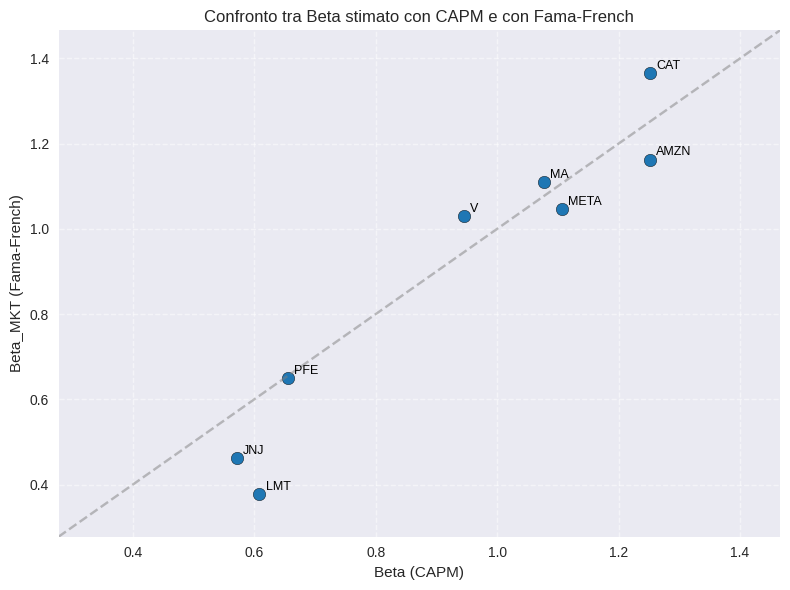

In [24]:
### Unione risultati CAPM e Fama-French

df_rischio = df_capm_res.merge(
    df_ff_res,
    on="Ticker",
    how="inner"
)

# Ordina per Beta_CAPM
df_rischio = df_rischio.sort_values("Beta", ascending=False)
print("📋 Tabella integrata CAPM + Fama-French:")
display(df_rischio.round(4))

### Grafico confronto Beta (CAPM vs Fama-French)
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(df_rischio["Beta"], df_rischio["Beta_MKT"],
           color="tab:blue", s=80, edgecolor="black")

for i, row in df_rischio.iterrows():
    ax.text(row["Beta"]+0.01, row["Beta_MKT"]+0.01, row["Ticker"],
            fontsize=9, color="black")

# Linea diagonale y=x per riferimento
lims = [
    min(df_rischio["Beta"].min(), df_rischio["Beta_MKT"].min())-0.1,
    max(df_rischio["Beta"].max(), df_rischio["Beta_MKT"].max())+0.1
]
ax.plot(lims, lims, linestyle="--", color="gray", alpha=0.5)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Beta (CAPM)")
ax.set_ylabel("Beta_MKT (Fama-French)")
ax.set_title("Confronto tra Beta stimato con CAPM e con Fama-French")
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


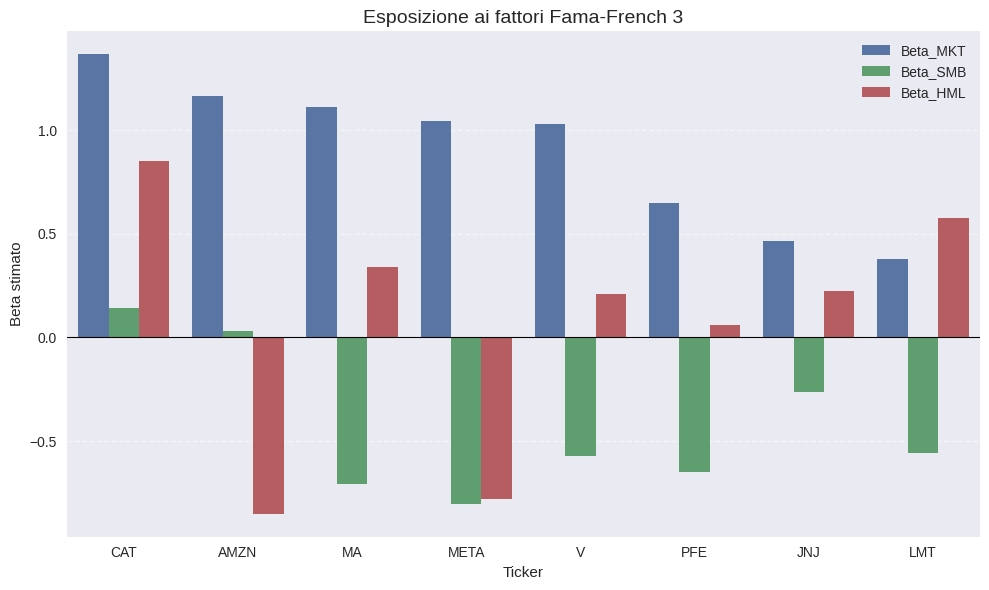

In [25]:
df_melt = df_ff_res.melt(
    id_vars="Ticker",
    value_vars=["Beta_MKT","Beta_SMB","Beta_HML"],
    var_name="Fattore", value_name="Beta"
)

plt.figure(figsize=(10,6))
sns.barplot(data=df_melt, x="Ticker", y="Beta", hue="Fattore")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Esposizione ai fattori Fama-French 3", fontsize=14)
plt.ylabel("Beta stimato")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


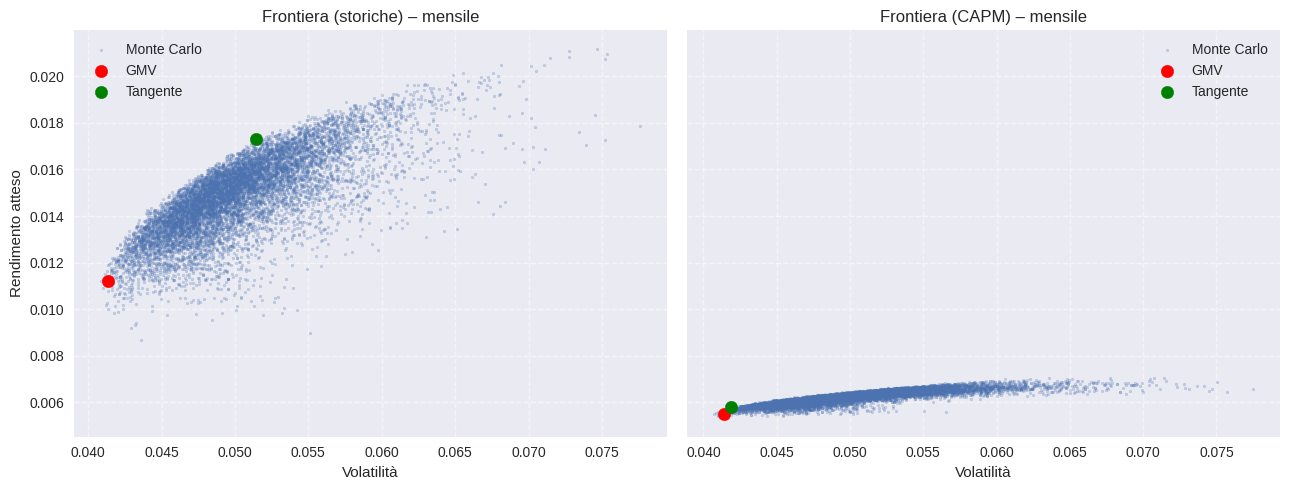

📋 Pesi percentuali dei portafogli (ordinati):


w_hist  w_capm  w_eq
LMT    33.17   11.70  12.5
AMZN   23.77    7.32  12.5
MA     17.18    0.00  12.5
META   10.99   10.00  12.5
V       8.15   13.36  12.5
JNJ     5.22   40.39  12.5
CAT     1.52    9.67  12.5
PFE     0.00    7.55  12.5

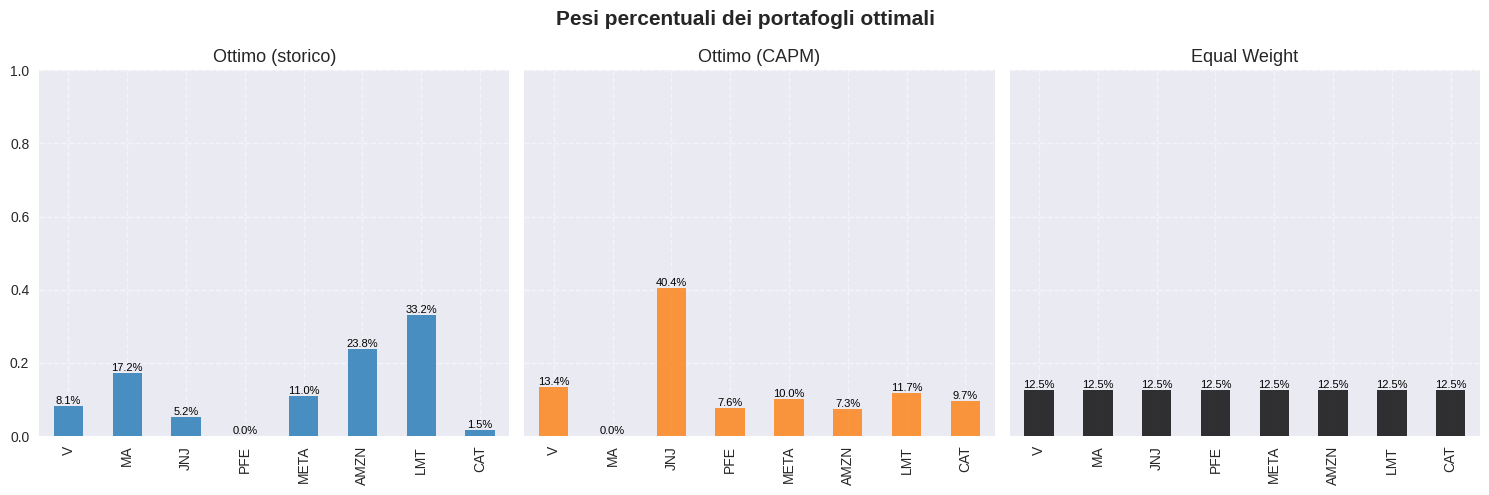

Beta (pesato) – Storico: 0.932, CAPM: 0.801, Equal: 0.934
Beta (regressione OOS) – Storico: 0.691, CAPM: 0.876, Equal: 0.929


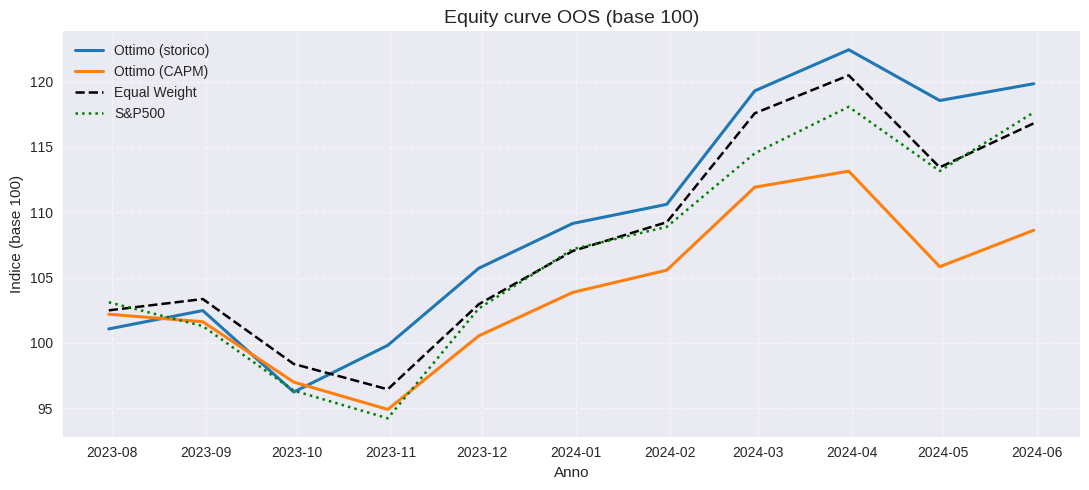


📊 Metriche OOS (successive ai 108 mesi di training):


Strategy    CAGR  Vol_ann  Sharpe   MaxDD
0  Ottimo (storico)  0.2182   0.1333  1.5532 -0.0608
1     Ottimo (CAPM)  0.0945   0.1376  0.7212 -0.0713
2      Equal Weight  0.1847   0.1477  1.2226 -0.0668
3            S&P500  0.1939   0.1491  1.2644 -0.0861

In [28]:
###
### FASE 7 — Costruzione di portafoglio (media-varianza)
###


###Setup & Split 108 mesi
assets = list(tickers)
ret_m = monthly_returns[assets].dropna()
spx_m = monthly_returns["SP500"].reindex(ret_m.index)

# primi 108 mesi per training
n_train = 108
ret_train = ret_m.iloc[:n_train]
ret_test  = ret_m.iloc[n_train:]
spx_train = spx_m.iloc[:n_train]
spx_test  = spx_m.iloc[n_train:]

mu_hist_m = ret_train.mean()
Sigma_m   = ret_train.cov()

mu_capm_a = df_capm_res.set_index("Ticker").loc[assets, "E(R_i)_CAPM"]
mu_capm_m = (1.0 + mu_capm_a)**(1/12) - 1.0


### Funzioni utili
def mean_variance_weights(Sigma, mu, target_mu=None, long_only=True):
    n = len(Sigma)
    Sigma_inv = np.linalg.pinv(Sigma.values)
    mu_vec = mu.values.reshape(-1,1)
    ones_vec = np.ones((n,1))

    if not long_only:
        A = float(ones_vec.T @ Sigma_inv @ ones_vec)
        B = float(ones_vec.T @ Sigma_inv @ mu_vec)
        C = float(mu_vec.T   @ Sigma_inv @ mu_vec)
        D = A*C - B*B
        w_gmv = ((Sigma_inv @ ones_vec) / A).flatten()
        w_tan_unnorm = (Sigma_inv @ mu_vec).flatten()
        w_tan = w_tan_unnorm / w_tan_unnorm.sum()
        if target_mu is not None:
            lam = (C*1 - B*target_mu)/D
            gam = (A*target_mu - B*1)/D
            w_trg = (lam*(Sigma_inv @ ones_vec) + gam*(Sigma_inv @ mu_vec)).flatten()
        else:
            w_trg = None
        return w_gmv, w_tan, w_trg

    def solve_qp(target_mu=None):
        n = Sigma.shape[0]
        Sigma_np = Sigma.values
        mu_np = mu.values
        def obj(w): return float(w.T @ Sigma_np @ w)
        cons = [{"type":"eq", "fun": lambda w: w.sum() - 1.0}]
        if target_mu is not None:
            cons.append({"type":"ineq", "fun": lambda w: mu_np @ w - target_mu})
        bounds = [(0.0,1.0)]*n
        w0 = np.ones(n)/n
        res = optimize.minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=cons)
        return res.x

    w_gmv = solve_qp(target_mu=None)

    def neg_sharpe(w):
        ret = mu.values @ w
        vol = np.sqrt(w @ Sigma.values @ w)
        return -ret/vol if vol>0 else 1e6
    cons_tan = [{"type":"eq", "fun": lambda w: w.sum() - 1.0}]
    bounds = [(0.0,1.0)]*len(mu)
    w0 = np.ones(len(mu))/len(mu)
    res_tan = optimize.minimize(neg_sharpe, w0, method="SLSQP", bounds=bounds, constraints=cons_tan)
    w_tan = res_tan.x

    target_mu = float(mu.mean()) if target_mu is None else float(target_mu)
    w_trg = solve_qp(target_mu=target_mu)
    return w_gmv, w_tan, w_trg

def mc_frontier(Sigma, mu, n_port=20000, long_only=True):
    n = len(mu)
    W,R,V = [],[],[]
    for _ in range(n_port):
        if long_only:
            w = np.random.dirichlet(np.ones(n))
        else:
            w = np.random.normal(0,1,n); w = w/np.sum(w)
        rr = float(mu.values @ w)
        vv = float(w @ Sigma.values @ w)
        W.append(w); R.append(rr); V.append(vv)
    df = pd.DataFrame(W, columns=mu.index)
    df["ret"] = R; df["vol"] = np.sqrt(V)
    return df

def metrics_series(r):
    n = len(r)
    cum = (1+r).prod()
    cagr = cum**(12/n)-1
    vol  = r.std(ddof=1)*np.sqrt(12)
    shar = (r.mean()*12)/vol if vol>0 else np.nan
    eq = (1+r).cumprod()
    dd = (eq/eq.cummax()-1).min()
    return cagr, vol, shar, dd


### Soluzioni analitiche + Monte Carlo

w_gmv_hist, w_tan_hist, w_trg_hist = mean_variance_weights(Sigma_m, mu_hist_m, long_only=True)
df_mc_hist = mc_frontier(Sigma_m, mu_hist_m, n_port=10000)

w_gmv_capm, w_tan_capm, w_trg_capm = mean_variance_weights(Sigma_m, mu_capm_m, long_only=True)
df_mc_capm = mc_frontier(Sigma_m, mu_capm_m, n_port=10000)


### Grafici frontiera

fig, ax = plt.subplots(1,2, figsize=(13,5), sharey=True)
for a, df_mc, mu, w_gmv, w_tan, title in [
    (ax[0], df_mc_hist, mu_hist_m, w_gmv_hist, w_tan_hist, "storiche"),
    (ax[1], df_mc_capm, mu_capm_m, w_gmv_capm, w_tan_capm, "CAPM")
]:
    a.scatter(df_mc["vol"], df_mc["ret"], s=4, alpha=0.25, label="Monte Carlo")
    a.scatter(np.sqrt(w_gmv @ Sigma_m.values @ w_gmv), mu.values @ w_gmv,
              color="red", s=80, label="GMV")
    a.scatter(np.sqrt(w_tan @ Sigma_m.values @ w_tan), mu.values @ w_tan,
              color="green", s=80, label="Tangente")
    a.set_title(f"Frontiera ({title}) – mensile")
    a.set_xlabel("Volatilità")
    a.grid(True, ls="--", alpha=0.5)
    a.legend()
ax[0].set_ylabel("Rendimento atteso")
plt.tight_layout(); plt.show()


### Pesi ottimali

w_opt_hist = pd.Series(w_tan_hist, index=assets, name="w_hist")
w_opt_capm = pd.Series(w_tan_capm, index=assets, name="w_capm")
w_eq       = pd.Series(np.ones(len(assets))/len(assets), index=assets, name="w_eq")

df_w = pd.concat([w_opt_hist, w_opt_capm, w_eq], axis=1)
df_w.to_csv("pesi_portafogli.csv")
print("📋 Pesi percentuali dei portafogli (ordinati):")
display((df_w*100).round(2).sort_values("w_hist", ascending=False))

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
palette = ["tab:blue", "tab:orange", "black"]
titles = ["Ottimo (storico)", "Ottimo (CAPM)", "Equal Weight"]
cols = ["w_hist", "w_capm", "w_eq"]
for ax, col, title, color in zip(axes, cols, titles, palette):
    bars = df_w[col].plot(kind="bar", ax=ax, color=color, alpha=0.8)
    ax.set_title(title, fontsize=13)
    ax.set_ylim(0, 1.0)
    ax.grid(True, ls="--", alpha=0.5)
    for p in bars.patches:
        ax.annotate(f"{p.get_height()*100:.1f}%",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=8, color="black")
fig.suptitle("Pesi percentuali dei portafogli ottimali", fontsize=15, weight="bold")
plt.tight_layout(); plt.show()

### Beta dei portafogli

beta_series = df_capm_res.set_index("Ticker")["Beta"].reindex(assets)
beta_hist_w = float((beta_series * w_opt_hist).sum())
beta_capm_w = float((beta_series * w_opt_capm).sum())
beta_eq_w   = float((beta_series * w_eq).sum())
print(f"Beta (pesato) – Storico: {beta_hist_w:.3f}, CAPM: {beta_capm_w:.3f}, Equal: {beta_eq_w:.3f}")

def beta_via_reg(returns_port, returns_mkt):
    df = pd.concat([returns_port, returns_mkt], axis=1).dropna()
    df.columns = ["Rp","Rm"]
    X = sm.add_constant(df["Rm"])
    model = sm.OLS(df["Rp"], X).fit()
    return model.params["Rm"], model

def portfolio_returns(ret_panel, w):
    return (ret_panel[assets] @ w).rename("Rp")

rp_hist_test = portfolio_returns(ret_test, w_opt_hist)
rp_capm_test = portfolio_returns(ret_test, w_opt_capm)
rp_eq_test   = portfolio_returns(ret_test, w_eq)

beta_hist_reg, _ = beta_via_reg(rp_hist_test, spx_test)
beta_capm_reg, _ = beta_via_reg(rp_capm_test, spx_test)
beta_eq_reg, _   = beta_via_reg(rp_eq_test,   spx_test)
print(f"Beta (regressione OOS) – Storico: {beta_hist_reg:.3f}, CAPM: {beta_capm_reg:.3f}, Equal: {beta_eq_reg:.3f}")

### Confronto OUT-OF-SAMPLE

eq_hist = (1 + rp_hist_test).cumprod()*100
eq_capm = (1 + rp_capm_test).cumprod()*100
eq_eq   = (1 + rp_eq_test).cumprod()*100
eq_spx  = (1 + spx_test).cumprod()*100

plt.figure(figsize=(11,5))
plt.plot(eq_hist, label="Ottimo (storico)", color="tab:blue", linewidth=2.2)
plt.plot(eq_capm, label="Ottimo (CAPM)",   color="tab:orange", linewidth=2.2)
plt.plot(eq_eq,   label="Equal Weight",    color="black", linestyle="--", linewidth=1.8)
plt.plot(eq_spx,  label="S&P500",          color="green", linestyle=":", linewidth=1.8)
plt.title("Equity curve OOS (base 100)", fontsize=14)
plt.ylabel("Indice (base 100)"); plt.xlabel("Anno")
plt.grid(True, ls="--", alpha=0.5); plt.legend()
plt.tight_layout(); plt.show()

m_hist = metrics_series(rp_hist_test)
m_capm = metrics_series(rp_capm_test)
m_eq   = metrics_series(rp_eq_test)
m_spx  = metrics_series(spx_test)

df_perf = pd.DataFrame({
    "Strategy": ["Ottimo (storico)","Ottimo (CAPM)","Equal Weight","S&P500"],
    "CAGR": [m_hist[0], m_capm[0], m_eq[0], m_spx[0]],
    "Vol_ann": [m_hist[1], m_capm[1], m_eq[1], m_spx[1]],
    "Sharpe": [m_hist[2], m_capm[2], m_eq[2], m_spx[2]],
    "MaxDD": [m_hist[3], m_capm[3], m_eq[3], m_spx[3]]
})
print("\n📊 Metriche OOS (successive ai 108 mesi di training):")
display(df_perf.round(4))
df_perf.to_csv("portafogli_OOS_metriche.csv", index=False)

